# Clustering

![FilterMethod](https://miro.medium.com/proxy/1*tc8UF-h0nQqUfLC8-0uInQ.gif)

Perform Clustering(Hierarchical, Kmeans & DBSCAN) for the crime data and identify the number of clusters formed and draw inferences.

Data Description:
Murder -- Muder rates in different places of United States
Assualt- Assualt rate in different places of United States
UrbanPop - urban population in different places of United States
Rape - Rape rate in different places of United States


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smf
import statsmodels.formula.api as sm
import scipy.stats as stats

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data=pd.read_csv(r"crime_data.csv")
print("Shape:",data.shape)
data.head()

Shape: (50, 5)


Unnamed: 0  Murder  Assault  UrbanPop  Rape
0     Alabama    13.2      236        58  21.2
1      Alaska    10.0      263        48  44.5
2     Arizona     8.1      294        80  31.0
3    Arkansas     8.8      190        50  19.5
4  California     9.0      276        91  40.6

### EDA and Data Visualization

In [4]:
print('\n Describe:');   print(data.describe())
print('\n Info:');   print(data.info())
print('\n Null values:');   print(data.isnull().sum())
print('\n Duplicated:');   print(data[data.duplicated()])


 Describe:
         Murder     Assault   UrbanPop       Rape
count  50.00000   50.000000  50.000000  50.000000
mean    7.78800  170.760000  65.540000  21.232000
std     4.35551   83.337661  14.474763   9.366385
min     0.80000   45.000000  32.000000   7.300000
25%     4.07500  109.000000  54.500000  15.075000
50%     7.25000  159.000000  66.000000  20.100000
75%    11.25000  249.000000  77.750000  26.175000
max    17.40000  337.000000  91.000000  46.000000

 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50 non-null     object 
 1   Murder      50 non-null     float64
 2   Assault     50 non-null     int64  
 3   UrbanPop    50 non-null     int64  
 4   Rape        50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB
None

 Null values:
Unnamed: 0    0
Murder        0
Assault       0
UrbanPop   

## Variable check

### Find columns with the same values

In [5]:
# Find columns with the same values
columns_with_same_values = data.columns[data.nunique() == 1].tolist()

for column in columns_with_same_values:
    unique_values = data[column].unique()
    print(f"Unique values in the '{column}' column:")
    print(unique_values)
    print()

# excluding columns_with_same_values
data = data.drop(columns=columns_with_same_values)
print("excluded columns_with_same_values, nos:",columns_with_same_values ,",Final shape:", data.shape)

excluded columns_with_same_values, nos: [] ,Final shape: (50, 5)


In [6]:
# Discrete Variables Count
discrete_feature=[feature for feature in data.columns if len(data[feature].unique())<20 and feature]
print('Discrete Variables Count: {}'.format(len(discrete_feature)))
print(discrete_feature)

# Continuous Feature Count
continuous_feature=[feature for feature in data.columns if data[feature].dtype!='O' and feature not in discrete_feature]
print('\nContinuous Feature Count {}'.format(len(continuous_feature)))
print(continuous_feature)

# Other Features Count
other_feature = [feature for feature in data.columns if feature not in discrete_feature and feature not in continuous_feature]
print('\nOther Features Count: {}'.format(len(other_feature)))
print('Other Features: {}'.format(other_feature))

# Numeric Data
numeric_data = data.select_dtypes(include='number')
print('\nNumeric Data Shape:', numeric_data.shape)
print(numeric_data.columns)

# Categorical Data
categorical_data = data.select_dtypes(include='object')
print('\nCategorical Data Shape:', categorical_data.shape)
print('Categorical Columns:', categorical_data.columns)

Discrete Variables Count: 0
[]

Continuous Feature Count 4
['Murder', 'Assault', 'UrbanPop', 'Rape']

Other Features Count: 1
Other Features: ['Unnamed: 0']

Numeric Data Shape: (50, 4)
Index(['Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')

Categorical Data Shape: (50, 1)
Categorical Columns: Index(['Unnamed: 0'], dtype='object')


## Categorical Data

Bar plot for all categorical

Labelencoder to convert categorical data into numeric

## Numeric Data

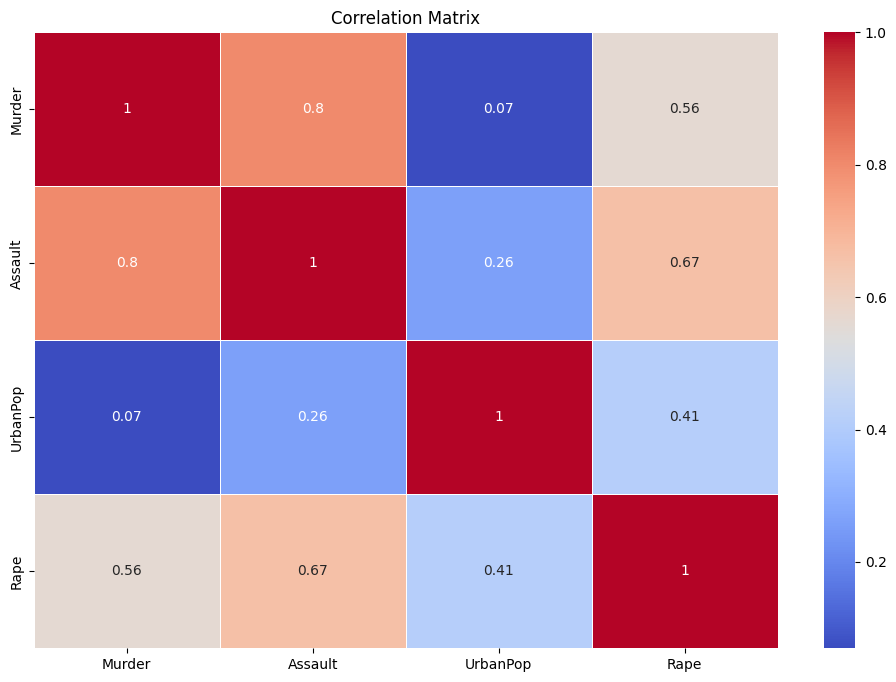

In [7]:
# Correlation Plot
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### visualization

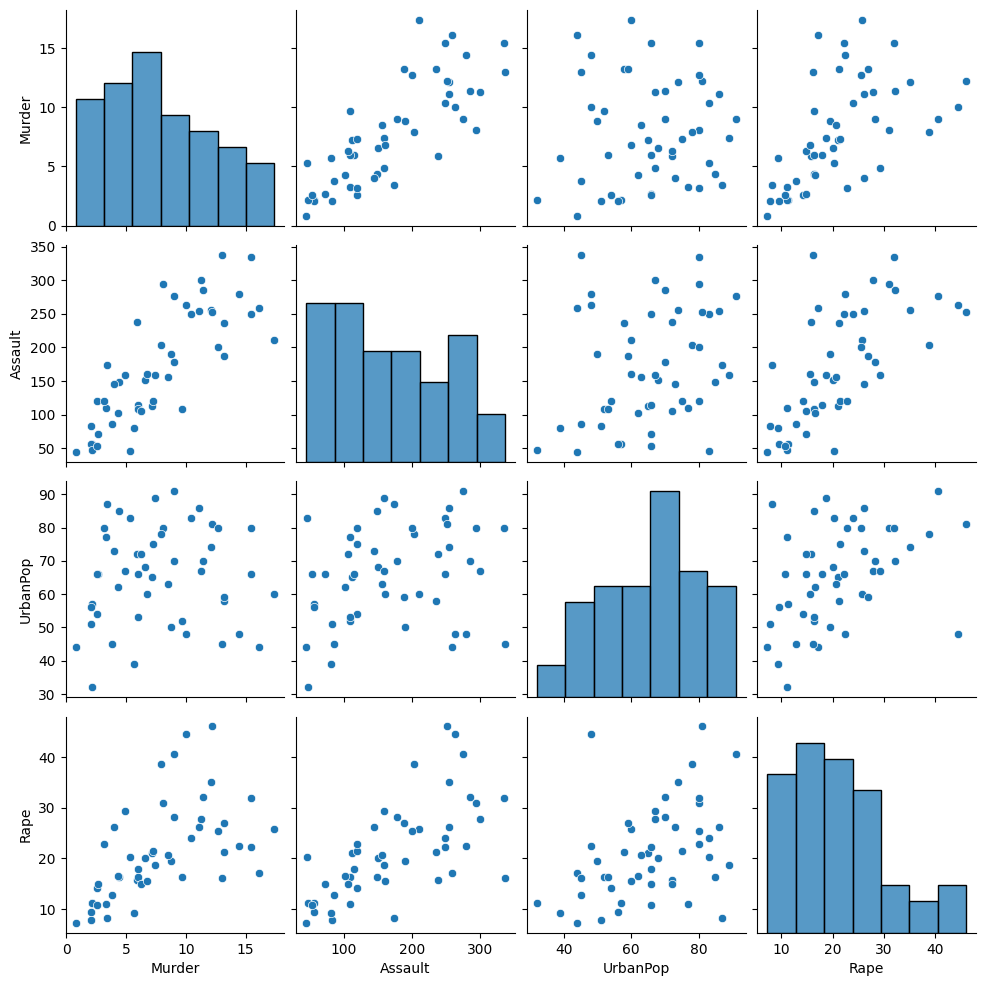

In [8]:
# relationship plot for numeric data
sns.pairplot(data= numeric_data)
plt.show()

### Detect outliers and handle them

In [9]:
data_filtered=pd.concat([numeric_data],axis=1)    #,cat_data ,numeric_data, data_2
data_filtered.shape

(50, 4)

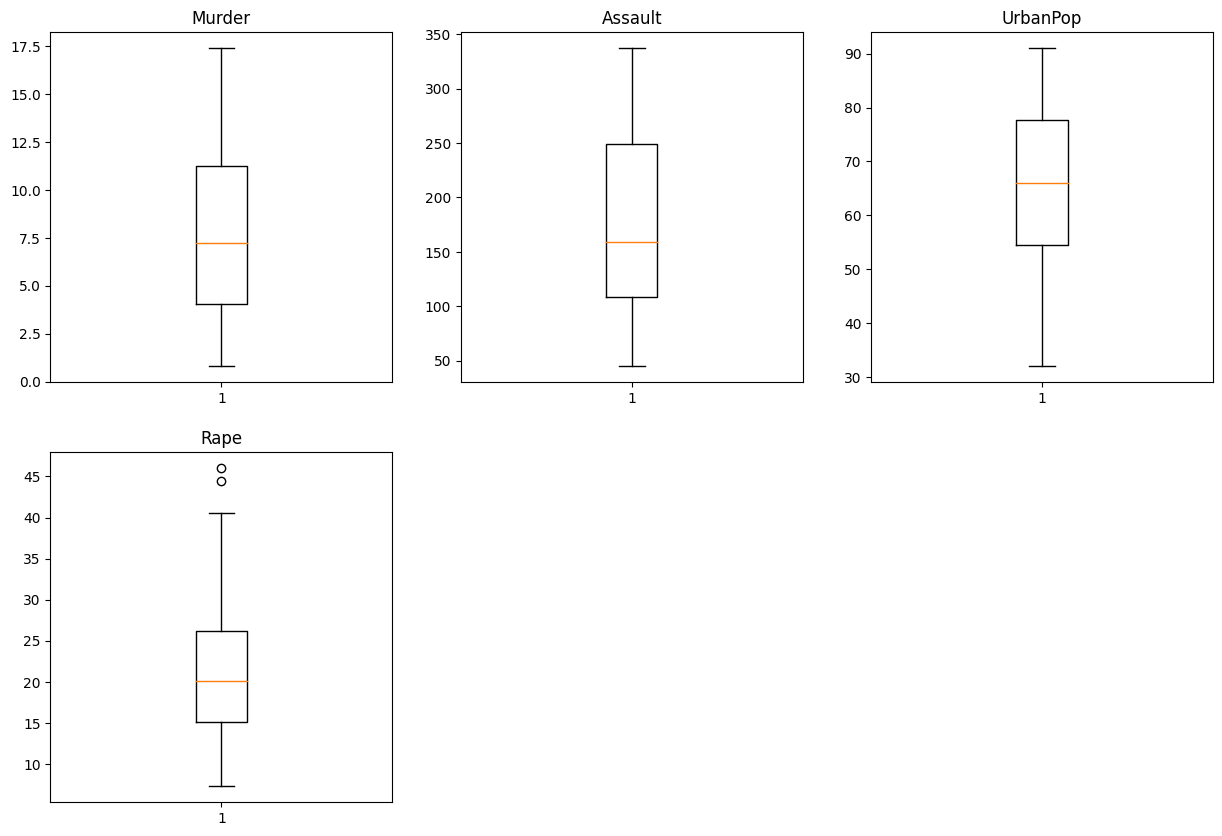

In [10]:
# display boxplots

num_columns = len(numeric_data.columns)
subplots_per_row = 3
num_rows = (num_columns + subplots_per_row - 1) // subplots_per_row

# Create subplots
fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(15, 5*num_rows))
axes = axes.flatten()

for i in range(num_columns):
    ax = axes[i]
    ax.boxplot(data_filtered.iloc[:, i])
    ax.set_title(data_filtered.columns[i])

# Hide any remaining empty subplots
for i in range(num_columns, num_rows * subplots_per_row):
    fig.delaxes(axes[i])

# plt.tight_layout()
plt.show()


#### Treating outliers with IQR

In [11]:
num_columns = len(numeric_data.columns)
new_data = data_filtered.copy()

for i in range(num_columns):
    # print("\n\nColumn Name:",(data_filtered.columns[i]))
    print("\n\nColumn Name: \033[1;34m" + "\033[1m" + data_filtered.columns[i] + "\033[0m")

    # Calculate the IQR
    Q1 = data_filtered.iloc[:, i].quantile(0.25)
    Q3 = data_filtered.iloc[:, i].quantile(0.75)
    IQR = Q3 - Q1
        
    # Identify and mark outliers using IQR
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(data_filtered[(data_filtered.iloc[:, i] > upper_bound) | (data_filtered.iloc[:, i] < lower_bound)].tail(2))
    
    # # Changing the outliers
    # new_data.loc[(new_data[data_filtered.columns[i]] > upper_bound), data_filtered.columns[i]] = upper_bound
    # new_data.loc[(new_data[data_filtered.columns[i]] < lower_bound), data_filtered.columns[i]] = lower_bound
    
    # # Drop rows with outliers
    # outliers = new_data[(new_data.iloc[:, i] < lower_bound) | (new_data.iloc[:, i] > upper_bound)].index   
    # new_data = new_data.drop(outliers)
    
print("\nShape of new data:",new_data.shape)
# sns.boxplot(data = new_data)
# plt.show()




Column Name: Murder
Empty DataFrame
Columns: [Murder, Assault, UrbanPop, Rape]
Index: []


Column Name: Assault
Empty DataFrame
Columns: [Murder, Assault, UrbanPop, Rape]
Index: []


Column Name: UrbanPop
Empty DataFrame
Columns: [Murder, Assault, UrbanPop, Rape]
Index: []


Column Name: Rape
    Murder  Assault  UrbanPop  Rape
1     10.0      263        48  44.5
27    12.2      252        81  46.0

Shape of new data: (50, 4)


Note: not removing outliers, 

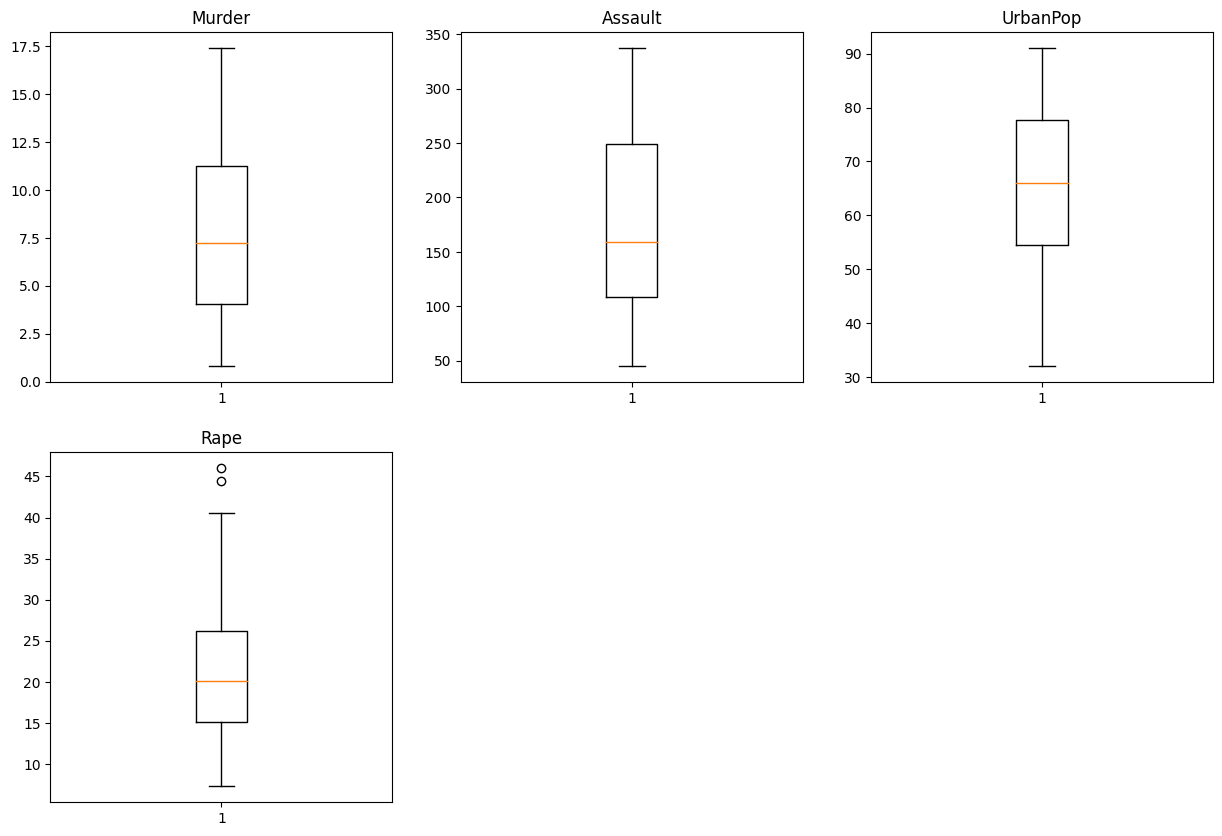

In [12]:
# display boxplots of Treated outliers with IQR

num_columns = len(new_data.columns)
subplots_per_row = 3
num_rows = (num_columns + subplots_per_row - 1) // subplots_per_row

# Create subplots
fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(15, 5*num_rows))
axes = axes.flatten()

for i in range(num_columns):
    ax = axes[i]
    ax.boxplot(new_data.iloc[:, i])
    ax.set_title(new_data.columns[i])

# Hide any remaining empty subplots
for i in range(num_columns, num_rows * subplots_per_row):
    fig.delaxes(axes[i])

# plt.tight_layout()
plt.show()


In [13]:
# # relationship plot for all data
# sns.pairplot(data= new_data)
# plt.show()

In [14]:
# to check repeatation iteration
# data_filtered=new_data

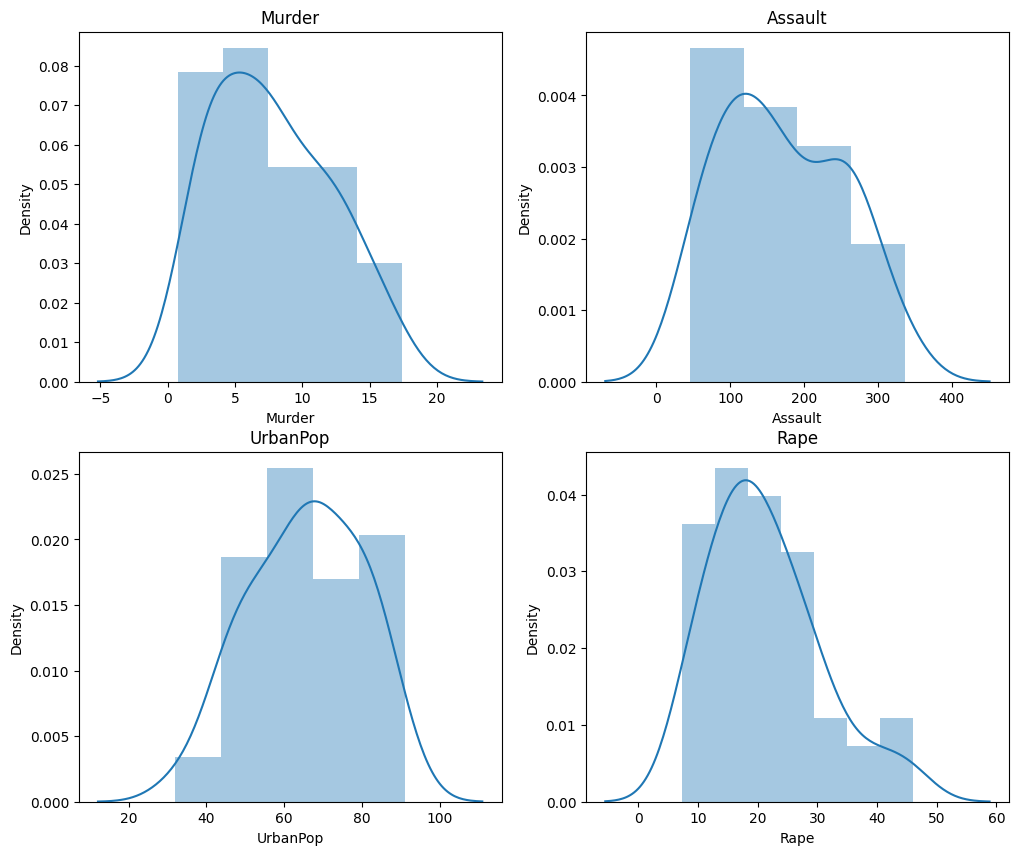

In [15]:
# distribution plots
subplots_per_row = 2
num_rows = (len(new_data.columns) + subplots_per_row - 1) // subplots_per_row
fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(12, 5*num_rows))
axes = axes.flatten()

for i, column in enumerate(new_data.columns):
    ax = axes[i]
    sns.distplot(new_data[column], kde=True, ax=ax)
    ax.set_title(column)
    
# Hide any remaining empty subplots
for i in range(len(new_data.columns), num_rows * subplots_per_row):
    fig.delaxes(axes[i])

# plt.tight_layout()
plt.show()


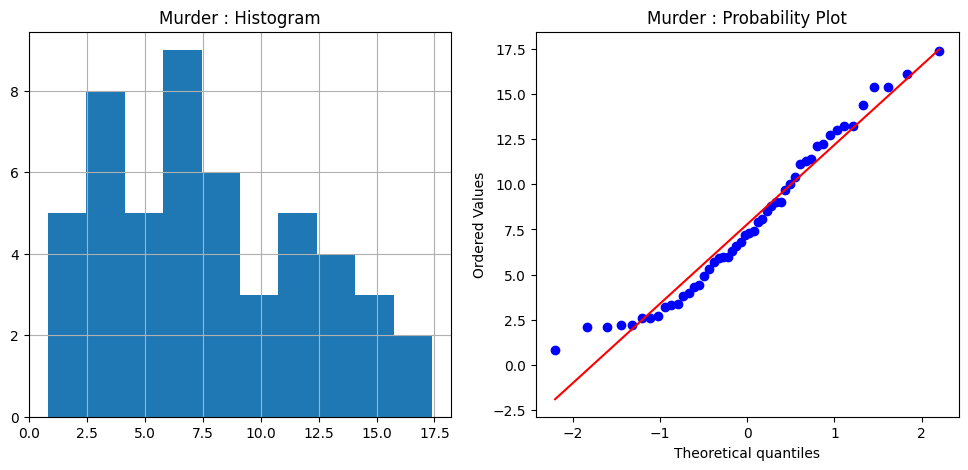

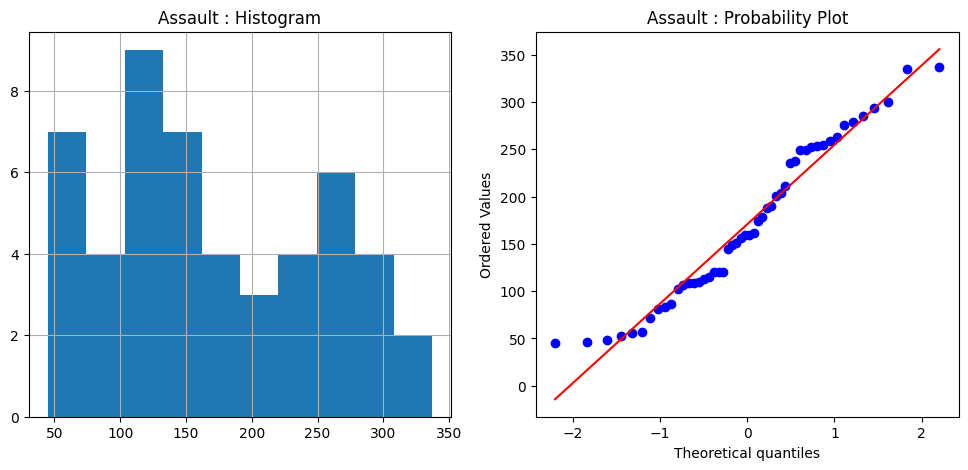

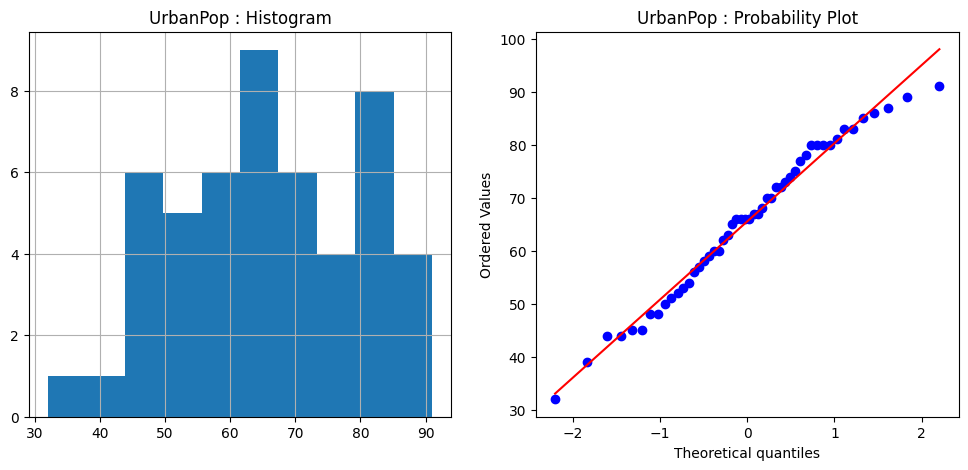

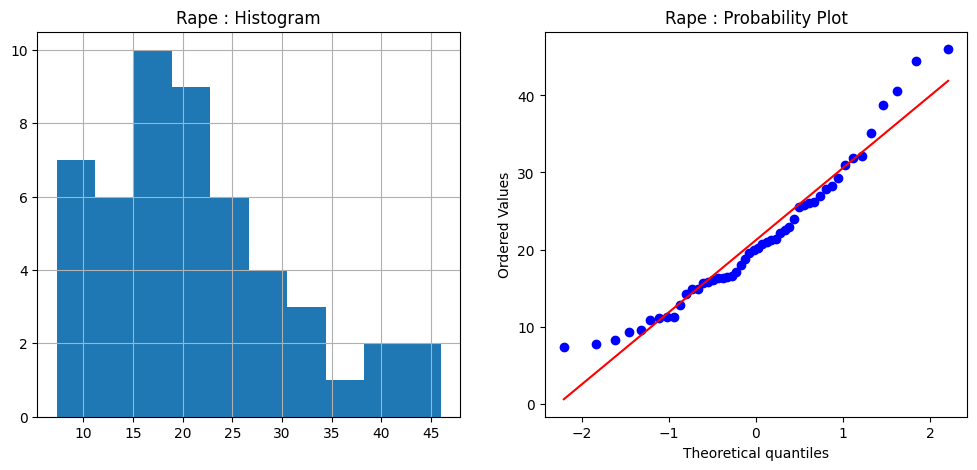

In [16]:
# Histogram & Probability Plot (Q-Q plot)
import pylab
import scipy.stats as stat

def plot_data(df, feature):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    df[feature].hist()
    plt.title(f'{feature} : Histogram')
    plt.subplot(1, 2, 2)
    stat.probplot(df[feature], dist='norm', plot=pylab)
    plt.title(f'{feature} : Probability Plot')

# Iterate through all columns
for column in new_data.columns:
    plot_data(new_data, column)
    plt.show()


### Feature scaling

# Clustering

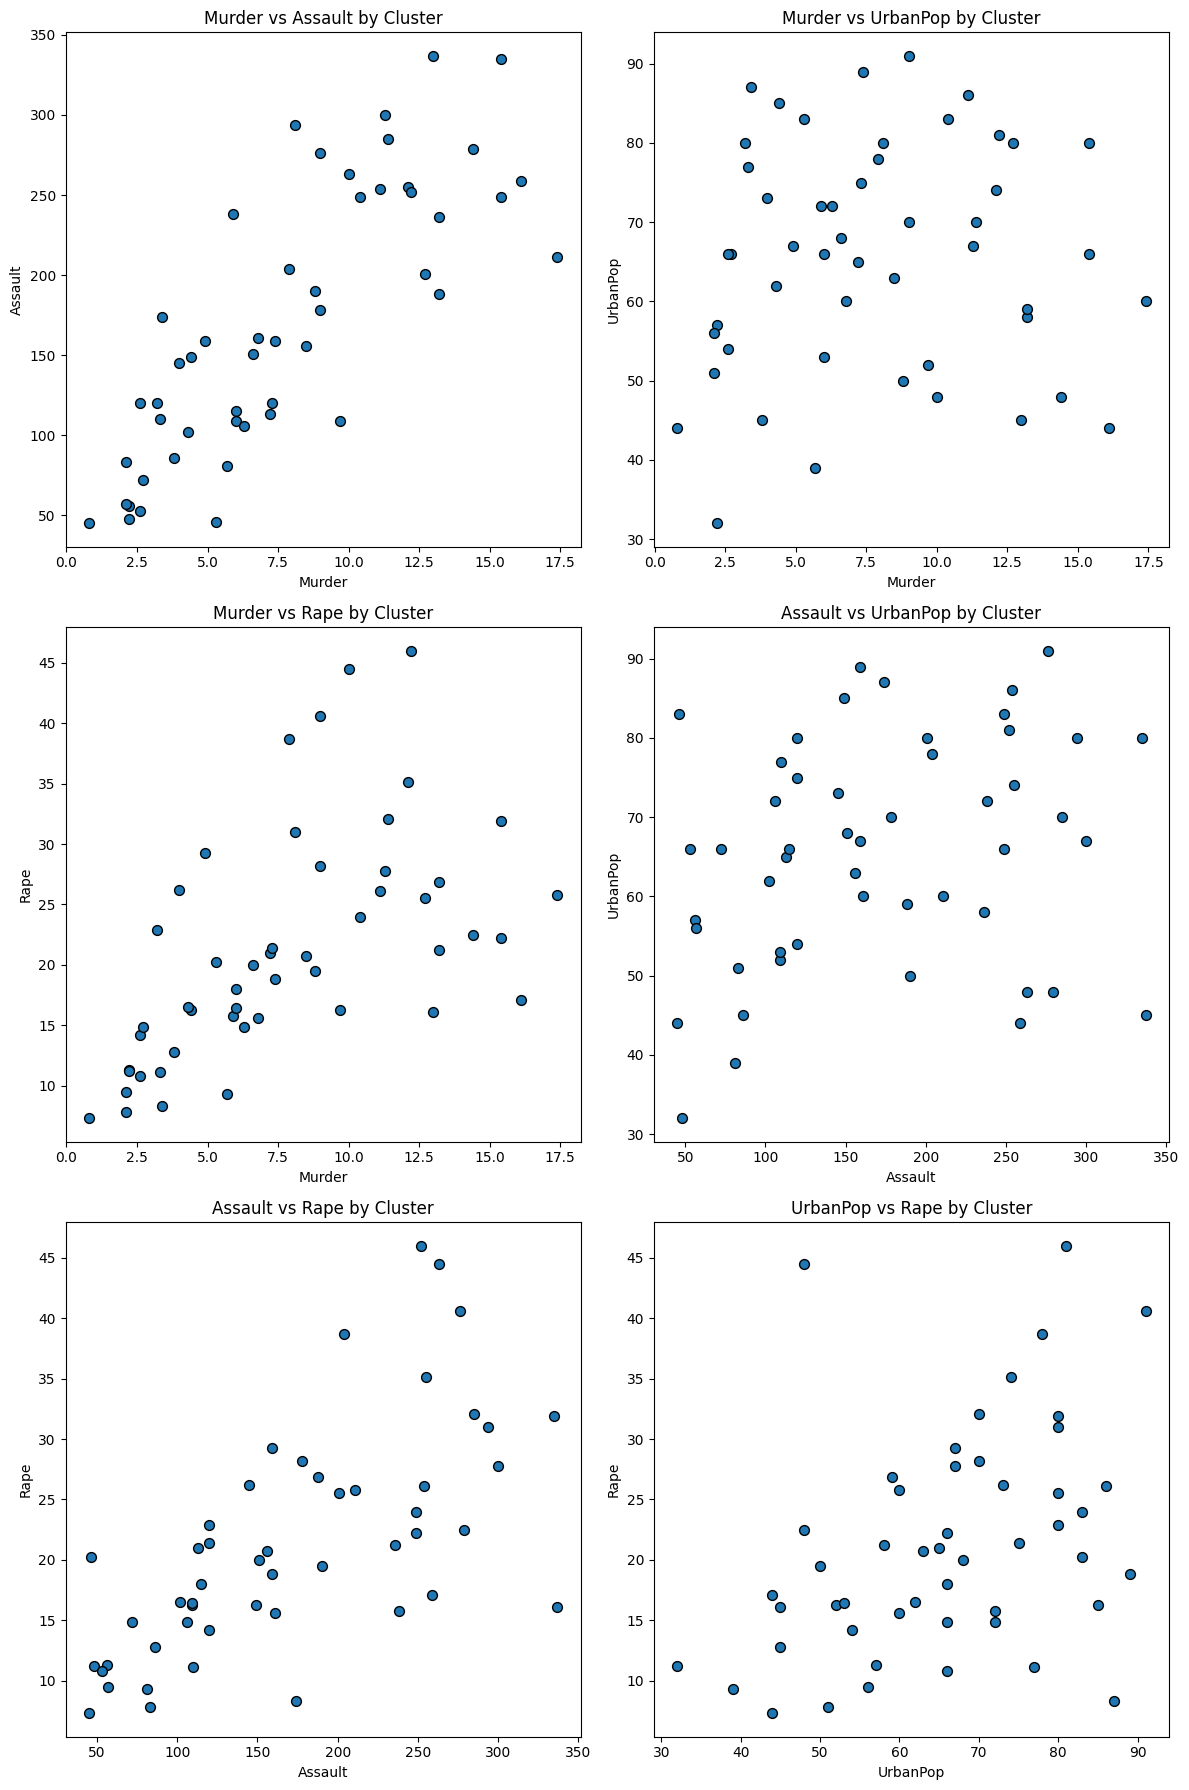

In [17]:
from scipy.special import comb
data_filtered = new_data[['Murder', 'Assault', 'UrbanPop', 'Rape']]
data_columns = data_filtered.columns
X=np.array(data_filtered)

num_columns = len(data_columns)
num_rows = int(np.ceil(comb(num_columns,2) / 2))  # Ensure an even number of columns doesn't leave an empty subplot
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 6 * num_rows))

count=0
for i, col1 in enumerate(data_columns):
    for j, col2 in enumerate(data_columns):
        if i != j and i<j:  # Avoid plotting the same column against itself
            row_index = count // 2
            col_index = count % 2
            count+=1
            # Scatter plot
            axes[row_index, col_index].scatter(X[:, i], X[:, j], cmap='viridis', s=50, edgecolors='k')  
            axes[row_index, col_index].set_title(f'{col1} vs {col2} by Cluster')
            axes[row_index, col_index].set_xlabel(col1)
            axes[row_index, col_index].set_ylabel(col2)


# Adjust layout
plt.tight_layout()
plt.show()


## hierarchical clustering

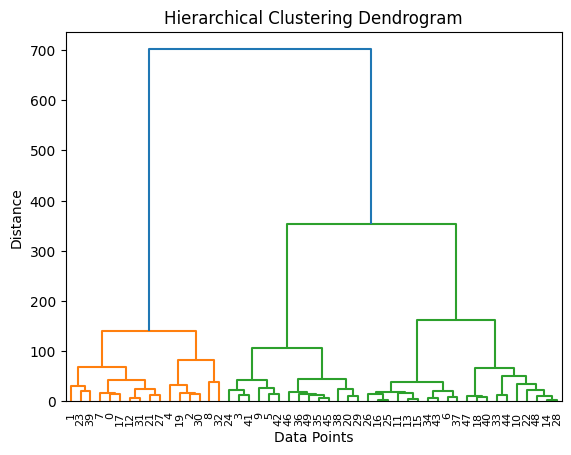

Labels: [1 1 1 2 1 2 0 1 1 2 0 0 1 0 0 0 0 1 0 1 2 1 0 1 2 0 0 1 0 2 1 1 1 0 0 2 2
 0 2 1 0 2 2 0 0 2 2 0 0 2] 
 Counts: (array([0, 1, 2], dtype=int64), array([20, 16, 14], dtype=int64))


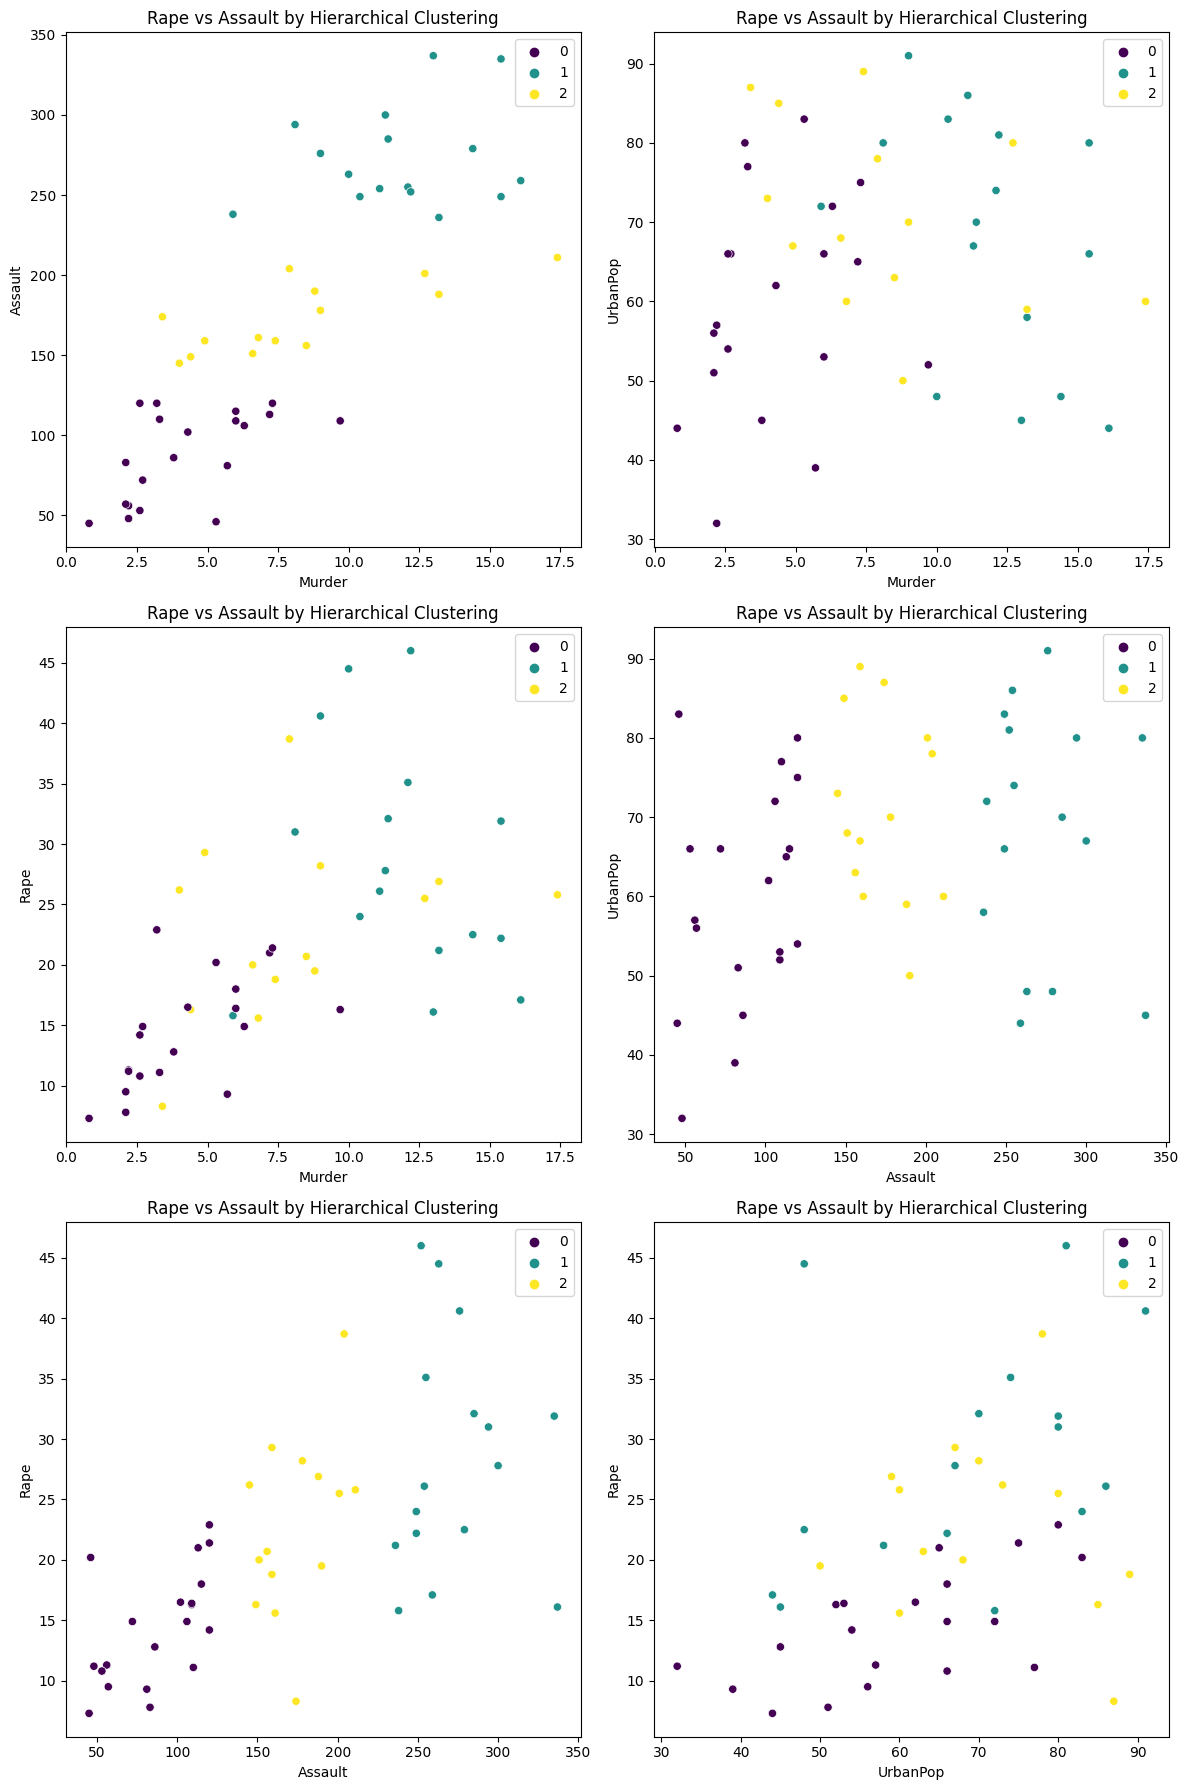

In [18]:
# Import necessary libraries
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Hierarchical clustering
df = new_data[['Murder', 'Assault', 'UrbanPop', 'Rape']]

# Linkage matrix
linkage_matrix = linkage(df, method='ward')     # method='complete'

# Dendrogram
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

# Agglomerative clustering
n_clusters = 3  # You can change the number of clusters as needed
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')   #affinity='euclidean', linkage='complete'
df['labels_pred'] = agg_clustering.fit_predict(df)
data_filtered['HC_labels_pred'] = agg_clustering.fit_predict(df)
labels_pred = agg_clustering.fit_predict(df)
print("Labels:" , labels_pred, "\n Counts:",np.unique(labels_pred, return_counts=True))

# Plot clustering 
cluster_column = 'labels_pred'  # Change this to your actual column name
# except the clustering column
data_columns = df.columns[df.columns != cluster_column]

num_columns = len(data_columns)
num_rows = int(np.ceil(comb(4, 2) / 2))  # Ensure an even number of columns doesn't leave an empty subplot
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 6 * num_rows))

count=0
for i, col1 in enumerate(data_columns):
    for j, col2 in enumerate(data_columns):
        if i != j and i<j :  # Avoid plotting the same column against itself
            row_index = (count) // 2
            col_index = count % 2
            count+=1
            
            sns.scatterplot(x=col1, y=col2, hue=cluster_column, data=df, palette='viridis', ax=axes[row_index, col_index])
            axes[row_index, col_index].set_title(f'{column} vs Assault by Hierarchical Clustering')
            axes[row_index, col_index].set_xlabel(col1)
            axes[row_index, col_index].set_ylabel(col2)
            axes[row_index, col_index].legend()

# Adjust layout
plt.tight_layout()
plt.show()


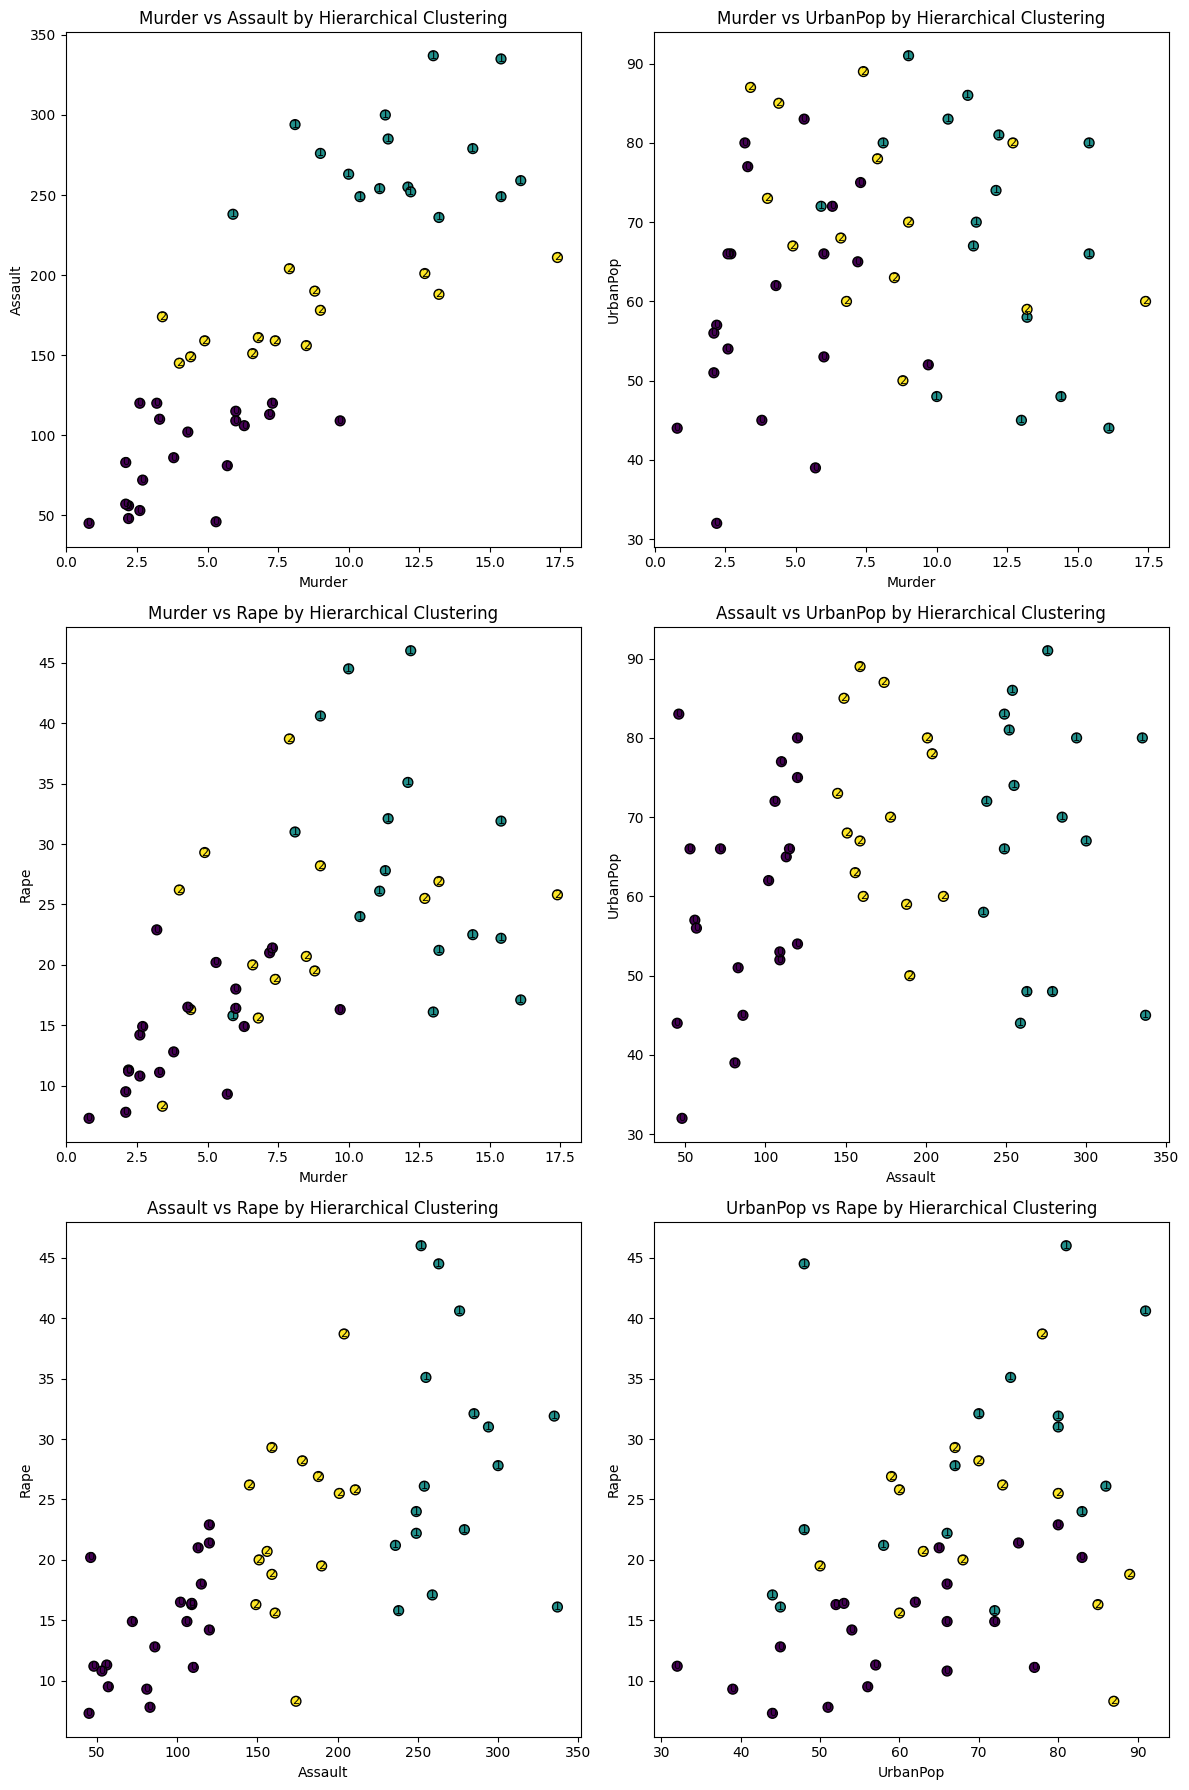

In [19]:
# Plot with Label Number
from scipy.special import comb
data_columns = df.columns[df.columns != cluster_column]
X=np.array(df)

num_columns = len(data_columns)
num_rows = int(np.ceil(comb(4, 2) / 2))  # Ensure an even number of columns doesn't leave an empty subplot
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 6 * num_rows))

count=0
for i, col1 in enumerate(data_columns):
    for j, col2 in enumerate(data_columns):
        if i != j and i<j :  # Avoid plotting the same column against itself
            row_index = (count) // 2
            col_index = count % 2
            count=count+1
            # Scatter plot
            axes[row_index, col_index].scatter(X[:, i], X[:, j], c=labels_pred, cmap='viridis', s=50, edgecolors='k')

            # Add cluster labels to each point
            for k, label in enumerate(labels_pred):
                axes[row_index, col_index].text(X[k, i], X[k, j], str(label), fontsize=8, ha='center', va='center')
            axes[row_index, col_index].set_title(f'{col1} vs {col2} by Hierarchical Clustering')
            axes[row_index, col_index].set_xlabel(col1)
            axes[row_index, col_index].set_ylabel(col2)

# Adjust layout
plt.tight_layout()
plt.show()


### visualize with 3d plot

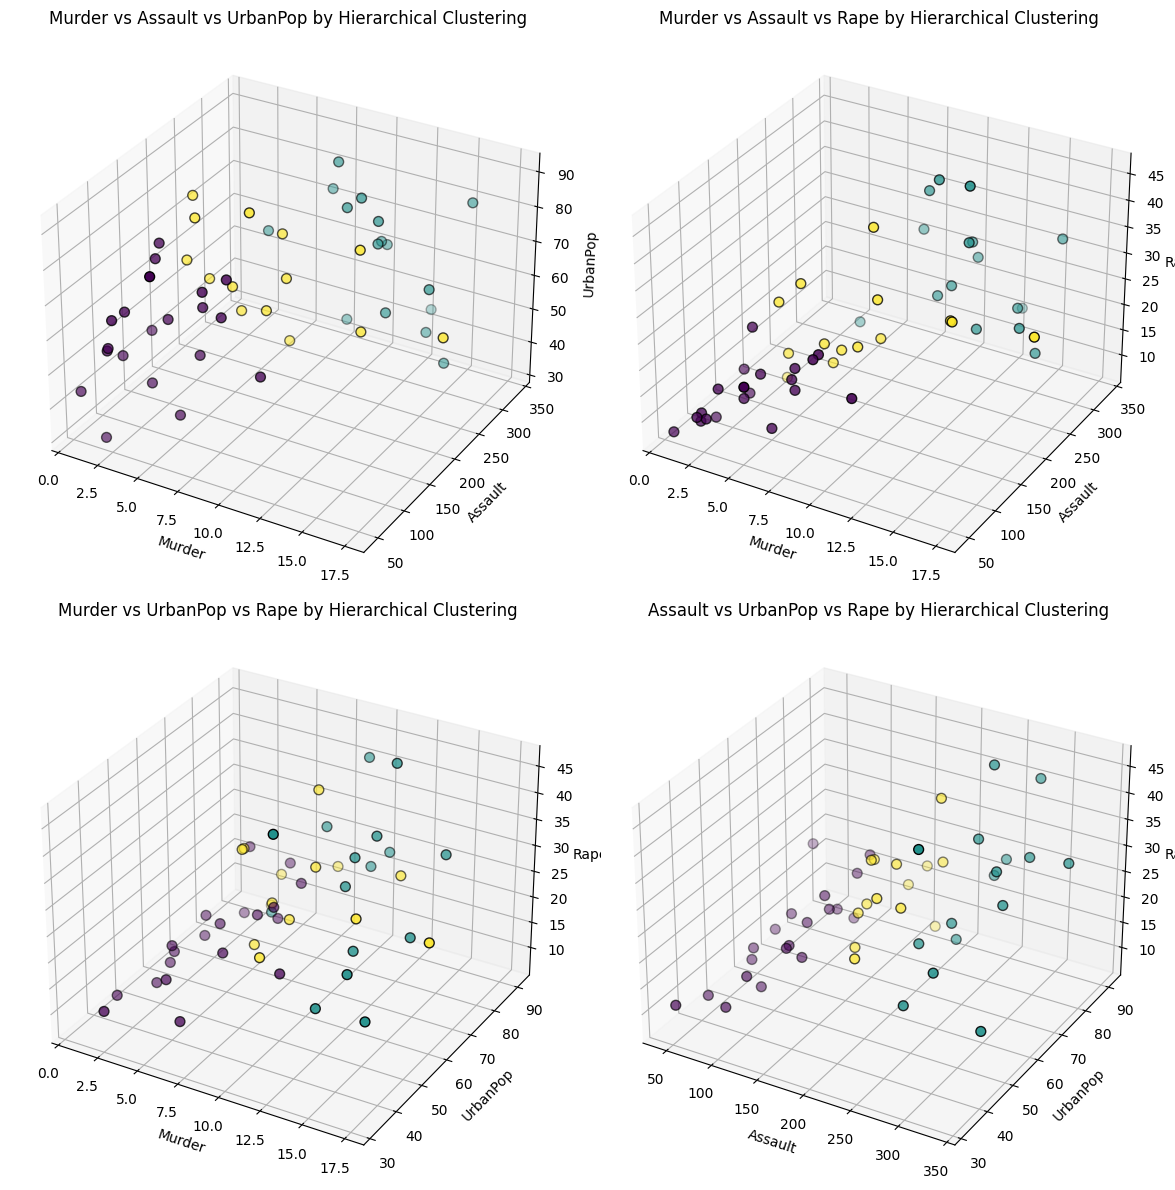

In [20]:
from mpl_toolkits.mplot3d import Axes3D

X=np.array(df)

num_columns = len(data_columns)
num_rows = int(np.ceil(comb(4, 3) / 2))  # Ensure an even number of columns doesn't leave an empty subplot
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 6 * num_rows), subplot_kw={'projection': '3d'})

count=0
for i in range(num_columns):
    for j in range(i + 1, num_columns):
        for k in range(j + 1, num_columns):
            row_index = count // 2
            col_index = count % 2
            count+=1

            # 3D Scatter plot
            axes[row_index, col_index].scatter(X[:, i], X[:, j], X[:, k], c=labels_pred, cmap='viridis', s=50, edgecolors='k')

            axes[row_index, col_index].set_title(f'{data_columns[i]} vs {data_columns[j]} vs {data_columns[k]} by Hierarchical Clustering')
            axes[row_index, col_index].set_xlabel(f'{data_columns[i]}')
            axes[row_index, col_index].set_ylabel(f'{data_columns[j]}')
            axes[row_index, col_index].set_zlabel(f'{data_columns[k]}')
            # axes[row_index, col_index].set_xlim([np.min(X[:, i]), np.max(X[:, i])])
            # axes[row_index, col_index].set_ylim([np.min(X[:, j]), np.max(X[:, j])])
            # axes[row_index, col_index].set_zlim([np.min(X[:, k]), np.max(X[:, k])])

# Adjust layout
plt.tight_layout()
plt.show()


With Normalization Data

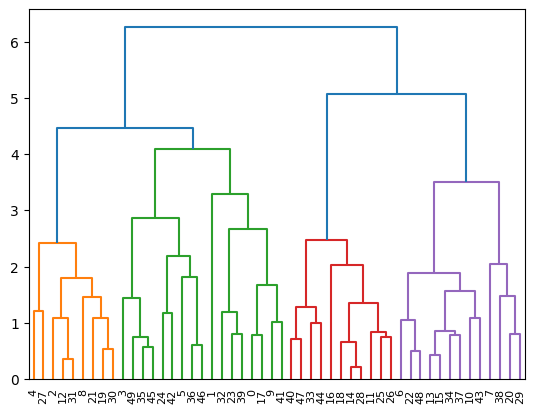

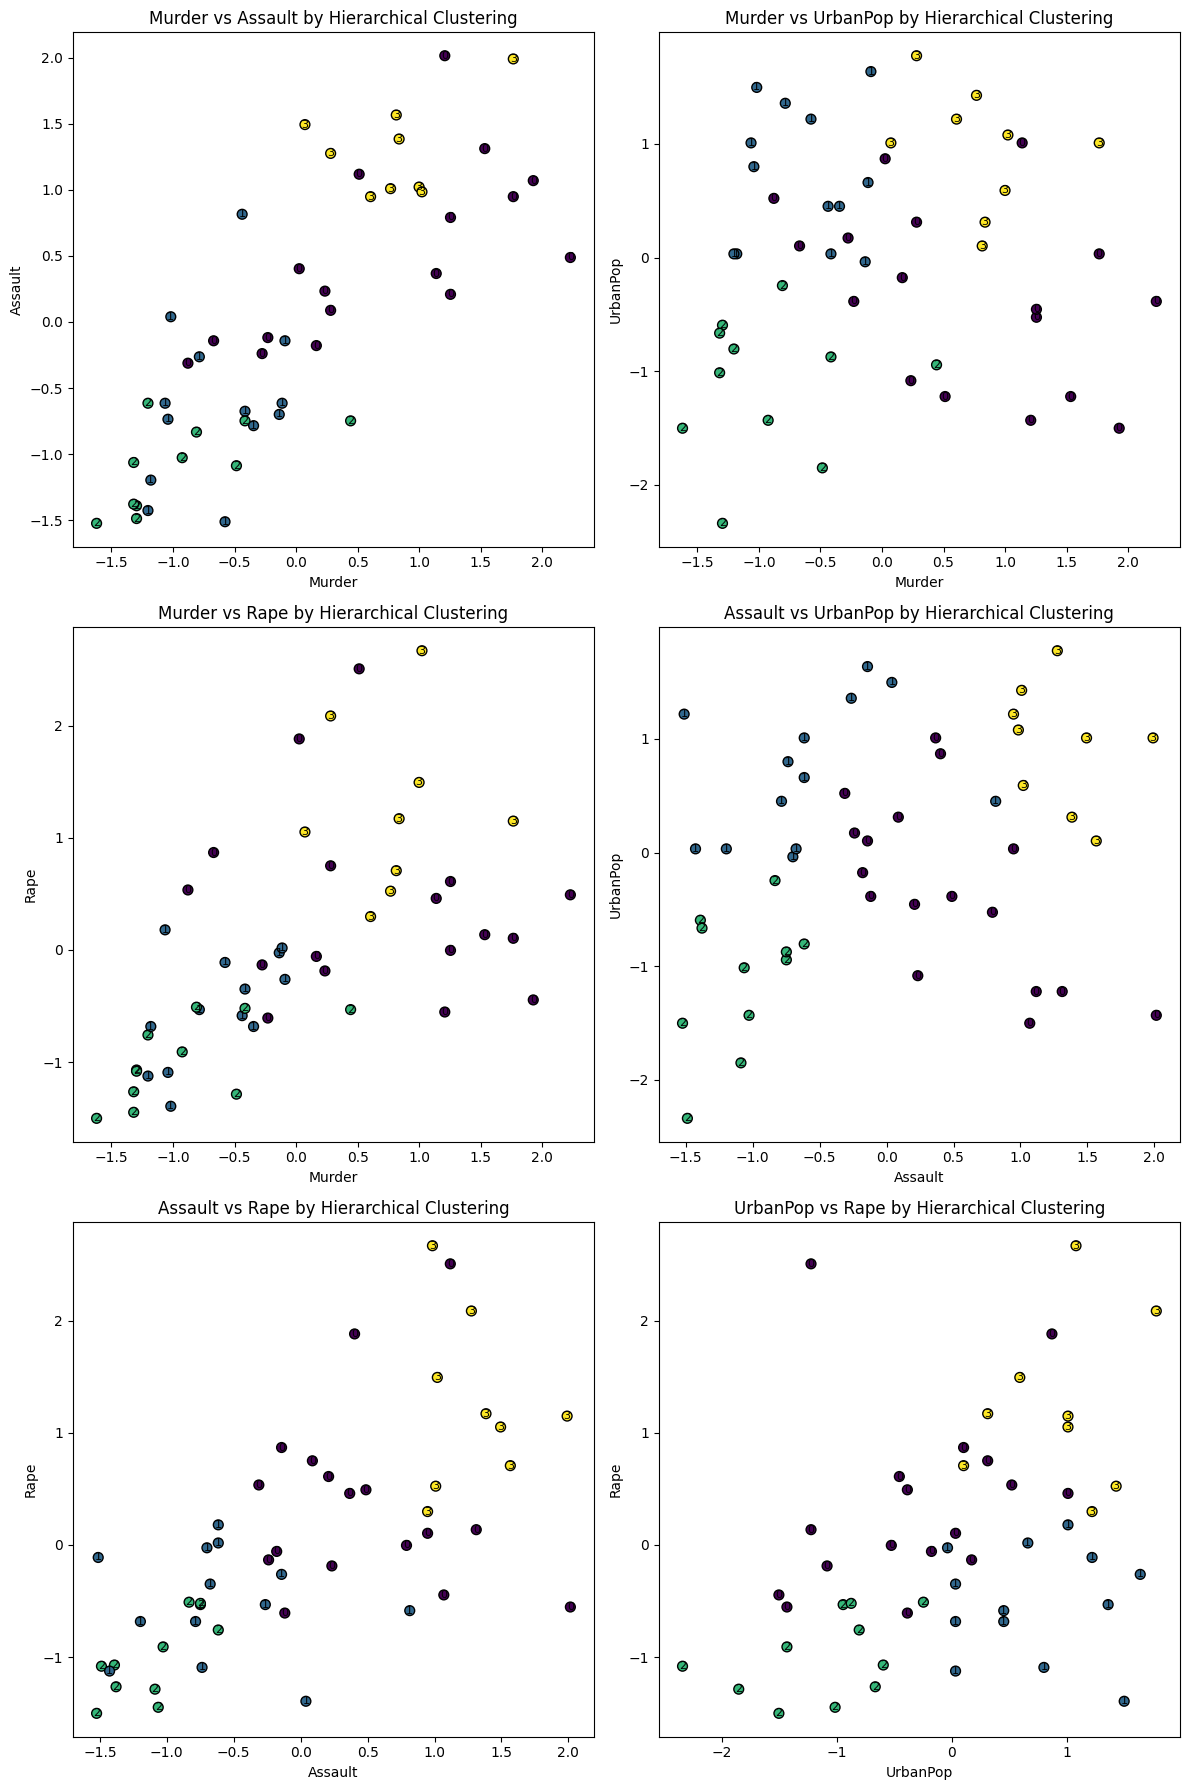

3D plot


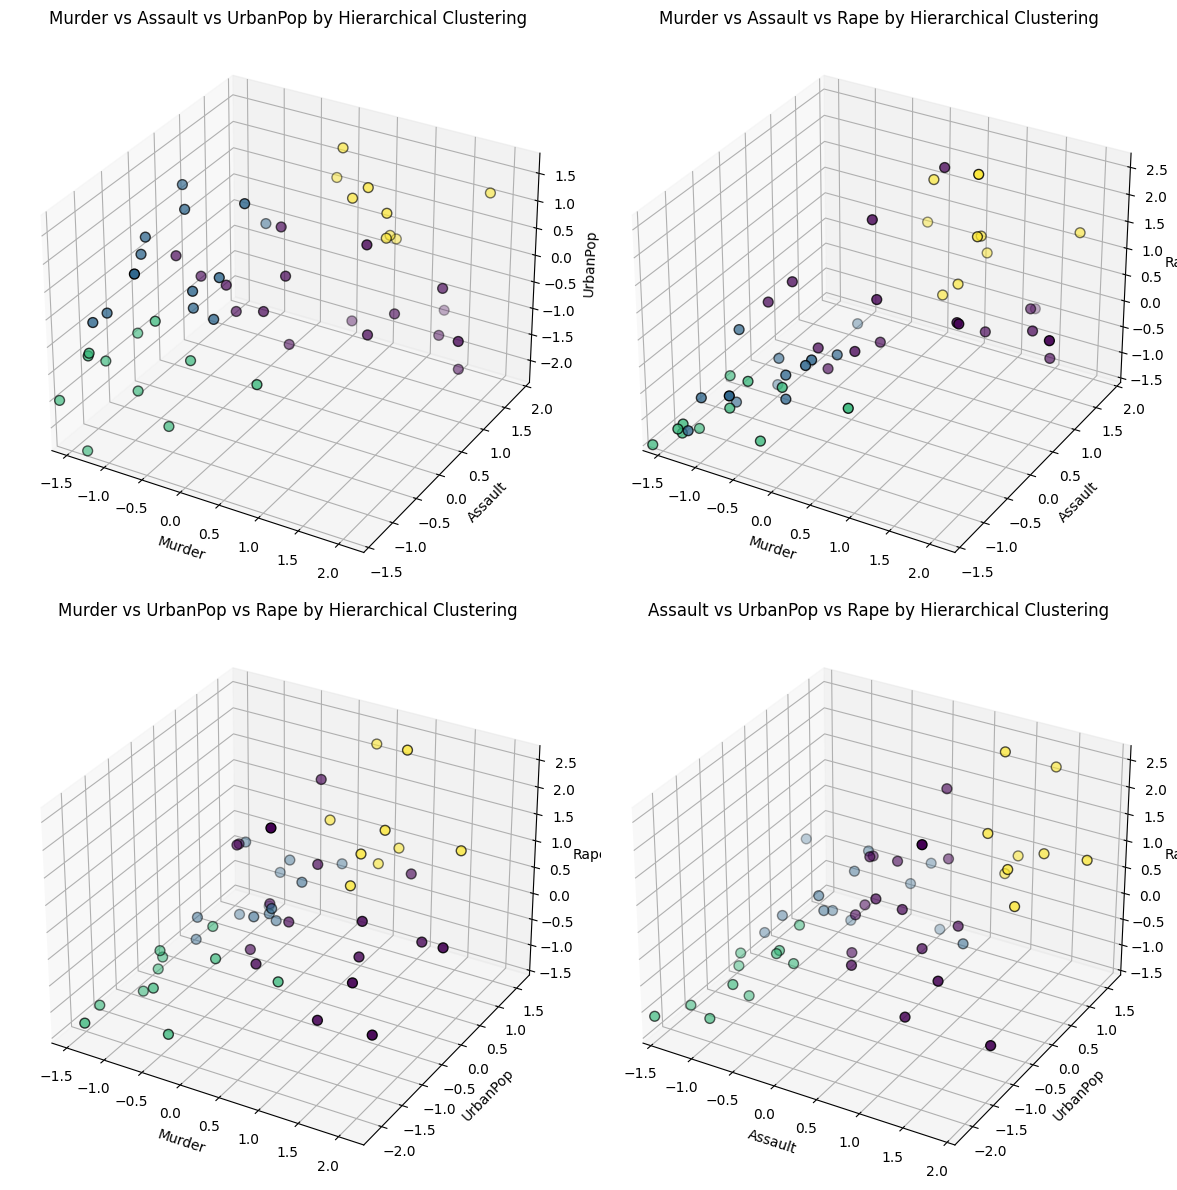

In [21]:
# With Normalization - Clustering 
from sklearn.preprocessing import StandardScaler
Norm = StandardScaler()    #Normalizer()        #
X = Norm.fit_transform(df)
dendrograms = dendrogram(linkage(X, method='complete'))
model = AgglomerativeClustering(n_clusters=4,affinity='euclidean', linkage='complete')
labels_pred = model.fit_predict(X)
data_filtered['HCN_labels_pred'] = labels_pred

 #Plot the clusters
data_columns = df.columns[df.columns != cluster_column]

num_columns = len(data_columns)
num_rows = int(np.ceil(comb(4, 2) / 2))  # Ensure an even number of columns doesn't leave an empty subplot
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 6 * num_rows))

count=0
for i, col1 in enumerate(data_columns):
    for j, col2 in enumerate(data_columns):
        if i != j and i<j :  # Avoid plotting the same column against itself
            row_index = (count) // 2
            col_index = count % 2
            count+=1

            # Scatter plot
            axes[row_index, col_index].scatter(X[:, i], X[:, j], c=labels_pred, cmap='viridis', s=50, edgecolors='k')

            # Add cluster labels to each point
            for k, label in enumerate(labels_pred):
                axes[row_index, col_index].text(X[k, i], X[k, j], str(label), fontsize=8, ha='center', va='center')
            axes[row_index, col_index].set_title(f'{col1} vs {col2} by Hierarchical Clustering')
            axes[row_index, col_index].set_xlabel(col1)
            axes[row_index, col_index].set_ylabel(col2)

# Adjust layout
plt.tight_layout()
plt.show()


# 3D plot
print("3D plot")
num_columns = len(data_columns)
num_rows = int(np.ceil(comb(4, 3) / 2))  # Ensure an even number of columns doesn't leave an empty subplot
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 6 * num_rows), subplot_kw={'projection': '3d'})

count=0
for i in range(num_columns):
    for j in range(i + 1, num_columns):
        for k in range(j + 1, num_columns):
            row_index = count // 2
            col_index = count % 2
            count+=1

            # 3D Scatter plot
            axes[row_index, col_index].scatter(X[:, i], X[:, j], X[:, k], c=labels_pred, cmap='viridis', s=50, edgecolors='k')

            axes[row_index, col_index].set_title(f'{data_columns[i]} vs {data_columns[j]} vs {data_columns[k]} by Hierarchical Clustering')
            axes[row_index, col_index].set_xlabel(f'{data_columns[i]}')
            axes[row_index, col_index].set_ylabel(f'{data_columns[j]}')
            axes[row_index, col_index].set_zlabel(f'{data_columns[k]}')
            axes[row_index, col_index].set_xlim([np.min(X[:, i]), np.max(X[:, i])])
            axes[row_index, col_index].set_ylim([np.min(X[:, j]), np.max(X[:, j])])
            axes[row_index, col_index].set_zlim([np.min(X[:, k]), np.max(X[:, k])])

# Adjust layout
plt.tight_layout()
plt.show()


## K_means clustering

![FilterMethod](https://miro.medium.com/max/1339/0*xu3GYMsWu9QiKNOo.png)

In [22]:
from sklearn.cluster import KMeans
df = new_data[['Murder', 'Assault', 'UrbanPop', 'Rape']]
X=np.array(df)
kmeans = KMeans(n_clusters=4, random_state=42)
labels_pred = kmeans.fit_predict(X)
print("Labels:" , labels_pred, "\n Counts:",np.unique(labels_pred, return_counts=True))
df['labels_pred'] = labels_pred 
data_filtered['Kmeans_labels_pred'] = labels_pred

Labels: [1 1 1 2 1 2 3 1 1 2 0 3 1 3 0 3 3 1 0 1 2 1 0 1 2 3 3 1 0 2 1 1 1 0 3 2 2
 3 2 1 0 2 2 3 0 2 2 0 0 2] 
 Counts: (array([0, 1, 2, 3]), array([10, 16, 14, 10], dtype=int64))


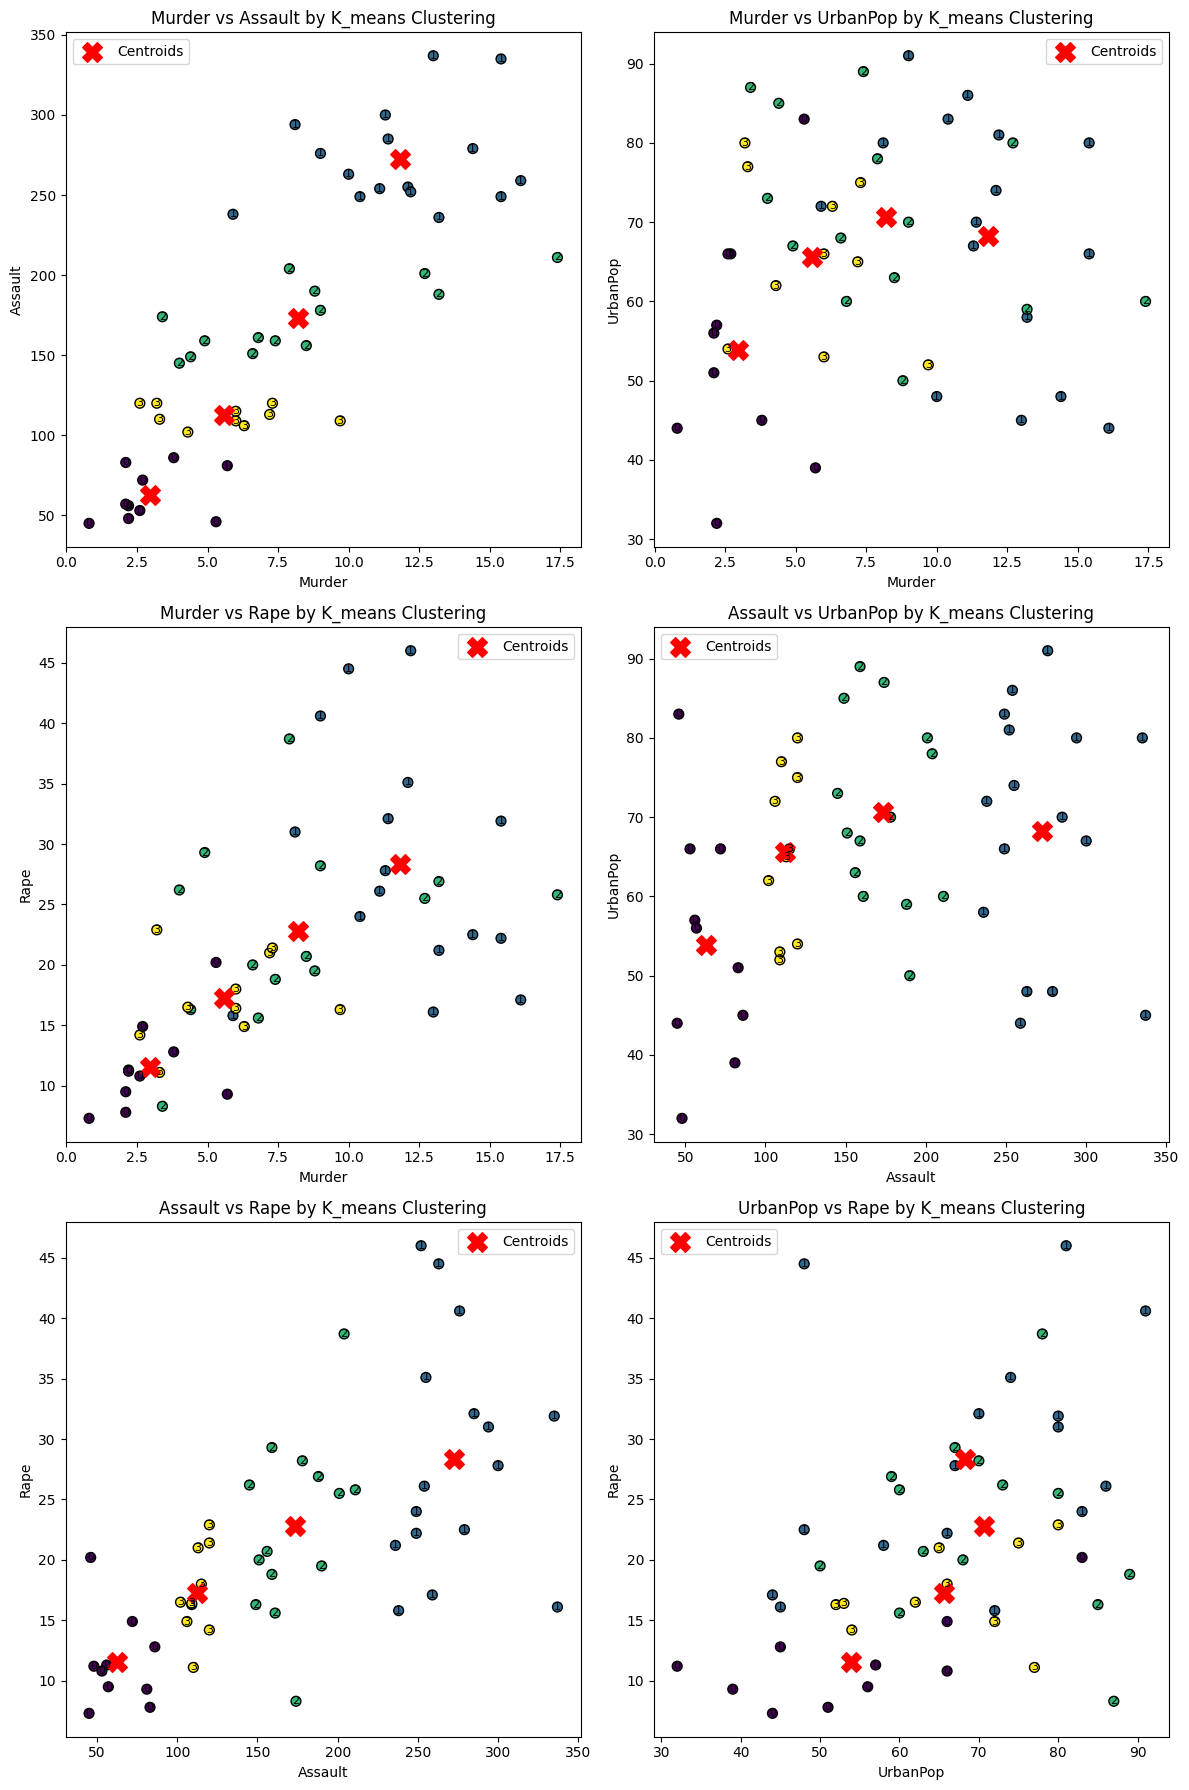

3D plot


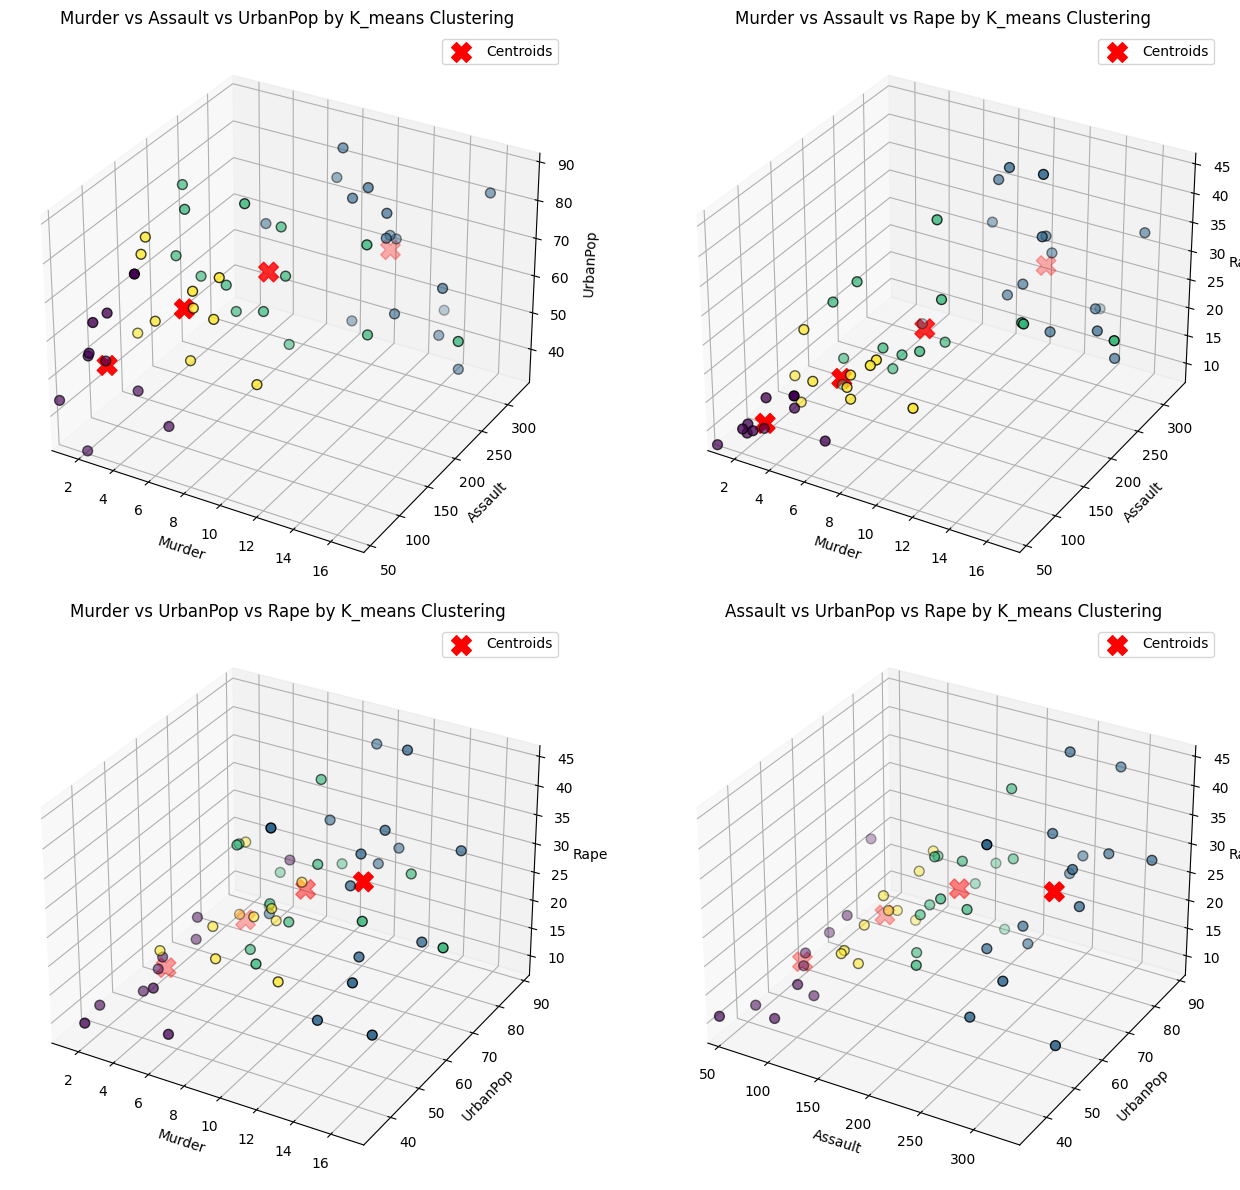

In [23]:
#Plot the clusters
data_columns = df.columns[df.columns != cluster_column]
num_columns = len(data_columns)
num_rows = int(np.ceil(comb(num_columns, 2) / 2))  # Ensure an even number of columns doesn't leave an empty subplot
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 6 * num_rows))

count=0
for i, col1 in enumerate(data_columns):
    for j, col2 in enumerate(data_columns):
        if i != j and i<j :  # Avoid plotting the same column against itself
            row_index = (count) // 2
            col_index = count % 2
            count+=1

            # Scatter plot
            axes[row_index, col_index].scatter(X[:, i], X[:, j], c=labels_pred, cmap='viridis', s=50, edgecolors='k')
            axes[row_index, col_index].scatter(kmeans.cluster_centers_[:, i], kmeans.cluster_centers_[:, j], c='red', marker='X', s=200, label='Centroids')
            axes[row_index, col_index].legend()

            # Add cluster labels to each point
            for k, label in enumerate(labels_pred):
                axes[row_index, col_index].text(X[k, i], X[k, j], str(label), fontsize=8, ha='center', va='center')
            axes[row_index, col_index].set_title(f'{col1} vs {col2} by K_means Clustering')
            axes[row_index, col_index].set_xlabel(col1)
            axes[row_index, col_index].set_ylabel(col2)
            

# Adjust layout
plt.tight_layout()
plt.show()


# 3D plot
print("3D plot")
num_columns = len(data_columns)
num_rows = int(np.ceil(comb(4, 3) / 2))  # Ensure an even number of columns doesn't leave an empty subplot
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, 6 * num_rows), subplot_kw={'projection': '3d'})

count=0
for i in range(num_columns):
    for j in range(i + 1, num_columns):
        for k in range(j + 1, num_columns):
            row_index = count // 2
            col_index = count % 2
            count+=1

            # 3D Scatter plot
            axes[row_index, col_index].scatter(X[:, i], X[:, j], X[:, k], c=labels_pred, cmap='viridis', s=50, edgecolors='k')
            axes[row_index, col_index].scatter(kmeans.cluster_centers_[:, i], kmeans.cluster_centers_[:, j], kmeans.cluster_centers_[:, k], c='red', marker='X', s=200, label='Centroids')
            axes[row_index, col_index].legend()
            axes[row_index, col_index].set_title(f'{data_columns[i]} vs {data_columns[j]} vs {data_columns[k]} by K_means Clustering')
            axes[row_index, col_index].set_xlabel(f'{data_columns[i]}')
            axes[row_index, col_index].set_ylabel(f'{data_columns[j]}')
            axes[row_index, col_index].set_zlabel(f'{data_columns[k]}')
            axes[row_index, col_index].set_xlim([np.min(X[:, i]), np.max(X[:, i])])
            axes[row_index, col_index].set_ylim([np.min(X[:, j]), np.max(X[:, j])])
            axes[row_index, col_index].set_zlim([np.min(X[:, k]), np.max(X[:, k])])
            

# Adjust layout
plt.tight_layout()
plt.show()

### Elbow Method - to find the optimal number of clusters (k)

Plot the sum of squared distances (inertia) for different values of k.  
Look for the "elbow" point where the rate of decrease slows down.   
The point where adding more clusters provides diminishing returns is often a good choice for k.

[355807.8216, 96399.02814449917, 47964.26535714286, 34728.629357142854, 24499.388190476187, 18875.46422222222, 15463.473777777777, 13329.361976190476, 12322.914999999999, 10468.535476190475]


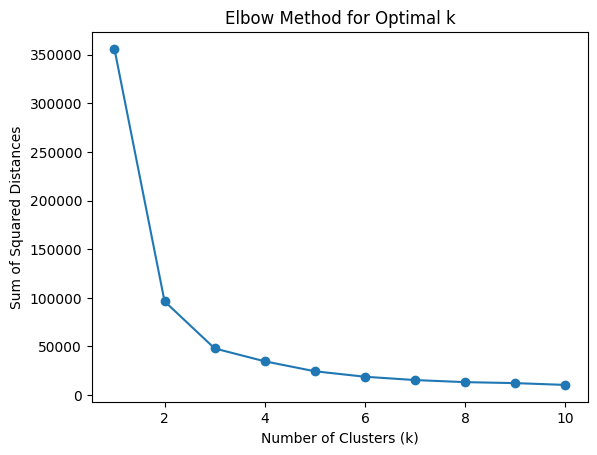

In [24]:
# Calculate sum of squared distances for different values of k
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)    
print(inertia_values)

# Plot the elbow graph
plt.plot(range(1, 11), inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.show()

### Silhouette Score - to find the optimal number of clusters (k)

Compute the silhouette score for different values of k.     
Choose the k with the highest silhouette score, where values range from -1 to 1, and higher values indicate better-defined clusters.

0.592655441935794


0.5319024108339817
0.5012332370891494
0.43926404403494984
0.4443431322464451
0.43994779028423564
0.4533593597198531
0.39138459651677043
0.3993600605815644


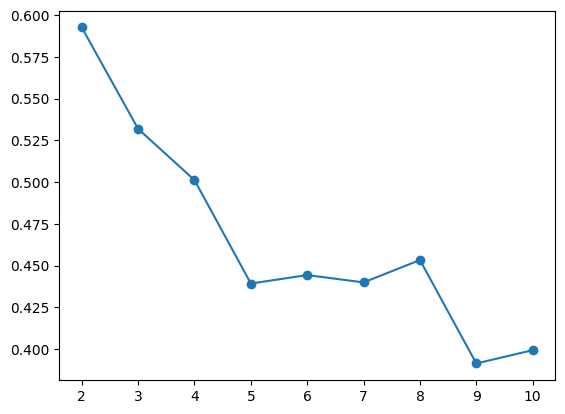

In [25]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score=silhouette_score(X, labels)
    print(score)
    silhouette_scores.append(score)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.show()


### Davies-Bouldin Index - to find the optimal number of clusters (k)

A lower Davies-Bouldin index indicates better clustering.       
Iterate over different values of k and choose the one that minimizes the Davies-Bouldin index.

0.5239130500719399


0.5973632980677114
0.5869723204307866
0.705140199939001
0.720732886252379
0.7592435739210223
0.7291915902648018
0.8373700036419883
0.8159668592087346


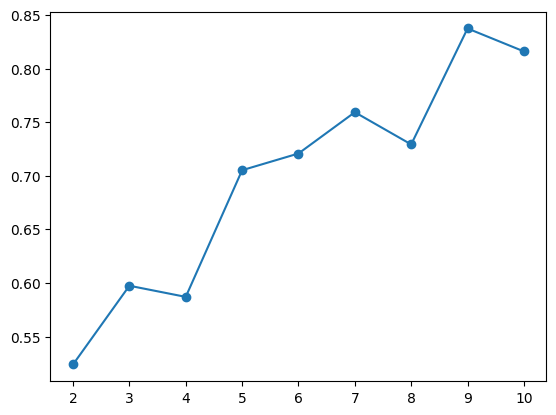

In [26]:
from sklearn.metrics import davies_bouldin_score
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score=davies_bouldin_score(X, labels)
    print(score)
    db_scores.append(score)
plt.plot(range(2, 11), db_scores, marker='o')
plt.show()


Note: Best clustering number is two

## DBScan clustering

![FilterMethod](https://miro.medium.com/max/627/1*yT96veo7Zb5QeswV7Vr7YQ.png)

Labels: [ 0 -1  1  1  2  1  1  1 -1  0  1  1  1  1  1  1  1  0  1  1  1  1  1  0
  1  1  1  2  1  1  1  1  0  1  1  1  1  1  1  0  1  0  1  1  1  1  1  1
  1  1] 
 Counts: (array([-1,  0,  1,  2], dtype=int64), array([ 2,  7, 39,  2], dtype=int64))


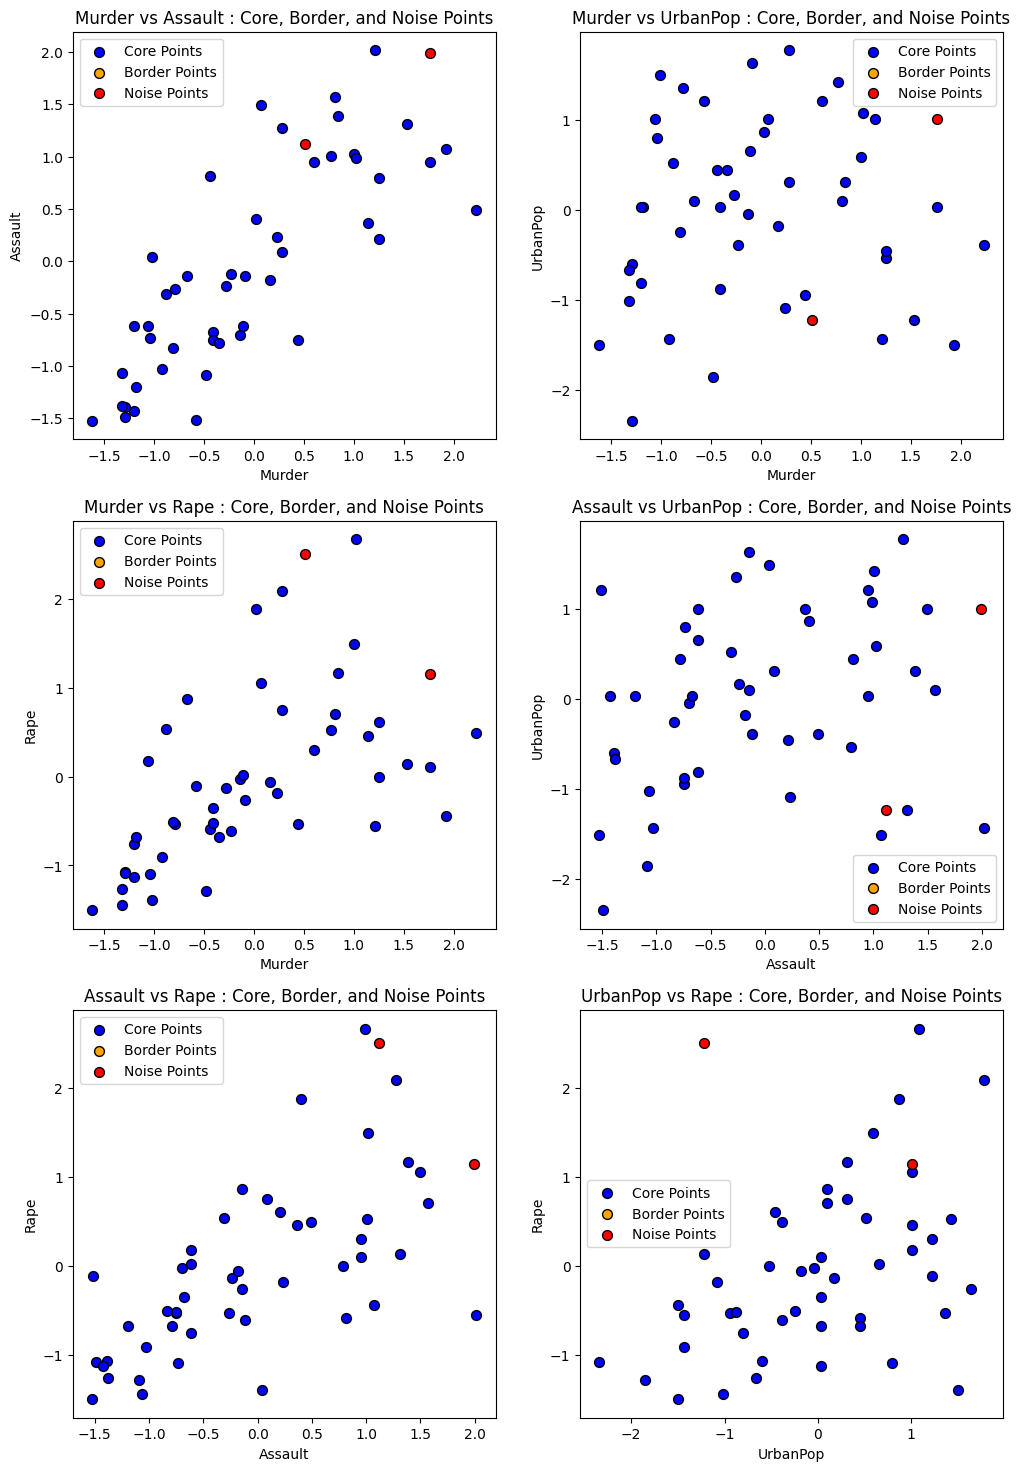

In [27]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

df = new_data[['Murder', 'Assault', 'UrbanPop', 'Rape']]
# df.drop(['Unnamed: 0'],axis=1,inplace=True)
# X=np.array(df)
stscaler = StandardScaler()
X = stscaler.fit_transform(df)
dbscan = DBSCAN(eps=1.25, min_samples=2)
dbscan.fit_predict(X)

# Extract cluster labels and outliers #Noisy samples are given the label -1.
labels_pred=dbscan.labels_
print("Labels:" , labels_pred, "\n Counts:",np.unique(labels_pred, return_counts=True))
df['labels_pred'] = labels_pred
data_filtered['DBSCAN_labels_pred'] = labels_pred

# Identify core, border, and noise points
core_samples_mask = np.zeros_like(labels_pred, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
border_samples_mask = (labels_pred != -1) & ~core_samples_mask
noise_samples_mask = (labels_pred == -1)

df1=X
# Plot the points with different colors for core, border, and noise points
data_columns = df.columns[df.columns != cluster_column]

num_columns = len(data_columns)
num_rows = int(np.ceil(comb(4, 2) / 2))  # Ensure an even number of columns doesn't leave an empty subplot
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 6 * num_rows))

count=0
for i, col1 in enumerate(data_columns):
    for j, col2 in enumerate(data_columns):
        if i != j and i<j :  # Avoid plotting the same column against itself
            row_index = (count) // 2
            col_index = count % 2
            count+=1

            # Scatter plot
            axes[row_index, col_index].scatter(df1[core_samples_mask, i], df1[core_samples_mask, j], c='blue', s=50, edgecolors='k', label='Core Points')
            axes[row_index, col_index].scatter(df1[border_samples_mask, i], df1[border_samples_mask, j], c='orange', s=50, edgecolors='k', label='Border Points')
            axes[row_index, col_index].scatter(df1[noise_samples_mask, i], df1[noise_samples_mask, j], c='red', s=50, edgecolors='k', label='Noise Points')
            
            axes[row_index, col_index].set_title(f'{col1} vs {col2} : Core, Border, and Noise Points')
            axes[row_index, col_index].set_xlabel(col1)
            axes[row_index, col_index].set_ylabel(col2)
            axes[row_index, col_index].legend()


plt.show()

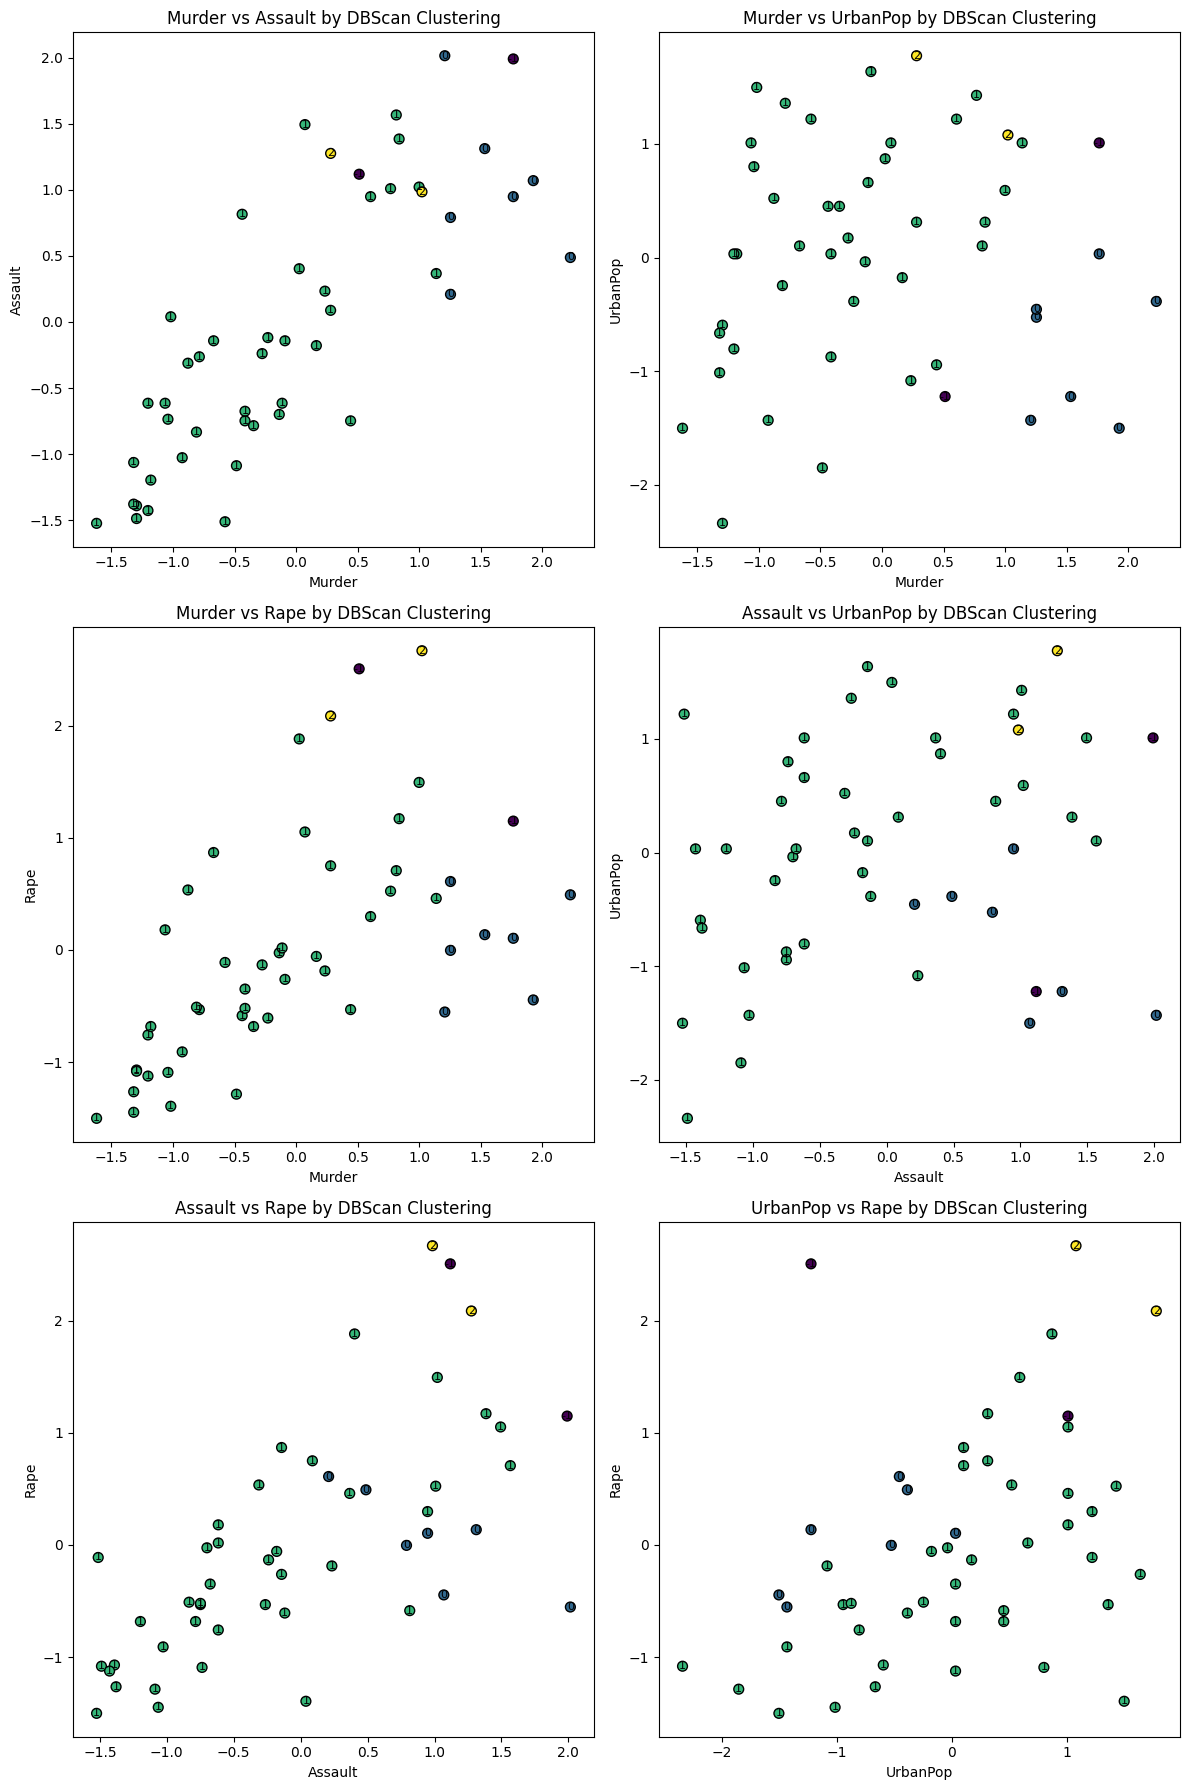

3D plot


In [28]:
#Plot the clusters
data_columns = df.columns[df.columns != cluster_column]

num_columns = len(data_columns)
num_rows = int(np.ceil(comb(4, 2) / 2))  # Ensure an even number of columns doesn't leave an empty subplot
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 6 * num_rows))

count=0
for i, col1 in enumerate(data_columns):
    for j, col2 in enumerate(data_columns):
        if i != j and i<j :  # Avoid plotting the same column against itself
            row_index = (count) // 2
            col_index = count % 2
            count+=1

            axes[row_index, col_index].scatter(X[:, i], X[:, j], c=labels_pred, cmap='viridis', s=50, edgecolors='k')

            # Add cluster labels to each point
            for k, label in enumerate(labels_pred):
                axes[row_index, col_index].text(X[k, i], X[k, j], str(label), fontsize=8, ha='center', va='center')
            axes[row_index, col_index].set_title(f'{col1} vs {col2} by DBScan Clustering')
            axes[row_index, col_index].set_xlabel(col1)
            axes[row_index, col_index].set_ylabel(col2)

# Adjust layout
plt.tight_layout()
plt.show()


# 3D plot
print("3D plot")
num_columns = len(data_columns)
num_rows = int(np.ceil(comb(4, 3) / 2))  # Ensure an even number of columns doesn't leave an empty subplot
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 6 * num_rows), subplot_kw={'projection': '3d'})

count=0
for i in range(num_columns):
    for j in range(i + 1, num_columns):
        for k in range(j + 1, num_columns):
            row_index = count // 2
            col_index = count % 2
            count+=1

            # 3D Scatter plot
            axes[row_index, col_index].scatter(X[:, i], X[:, j], X[:, k], c=labels_pred, cmap='viridis', s=50, edgecolors='k')

            axes[row_index, col_index].set_title(f'{data_columns[i]} vs {data_columns[j]} vs {data_columns[k]} by DBScan Clustering')
            axes[row_index, col_index].set_xlabel(f'{data_columns[i]}')
            axes[row_index, col_index].set_ylabel(f'{data_columns[j]}')
            axes[row_index, col_index].set_zlabel(f'{data_columns[k]}')
            axes[row_index, col_index].set_xlim([np.min(X[:, i]), np.max(X[:, i])])
            axes[row_index, col_index].set_ylim([np.min(X[:, j]), np.max(X[:, j])])
            axes[row_index, col_index].set_zlim([np.min(X[:, k]), np.max(X[:, k])])

# Adjust layout
plt.tight_layout()
plt.show()

### silhouette_score -how many clusters were genreated by the algorithm for the respective parameters combinations

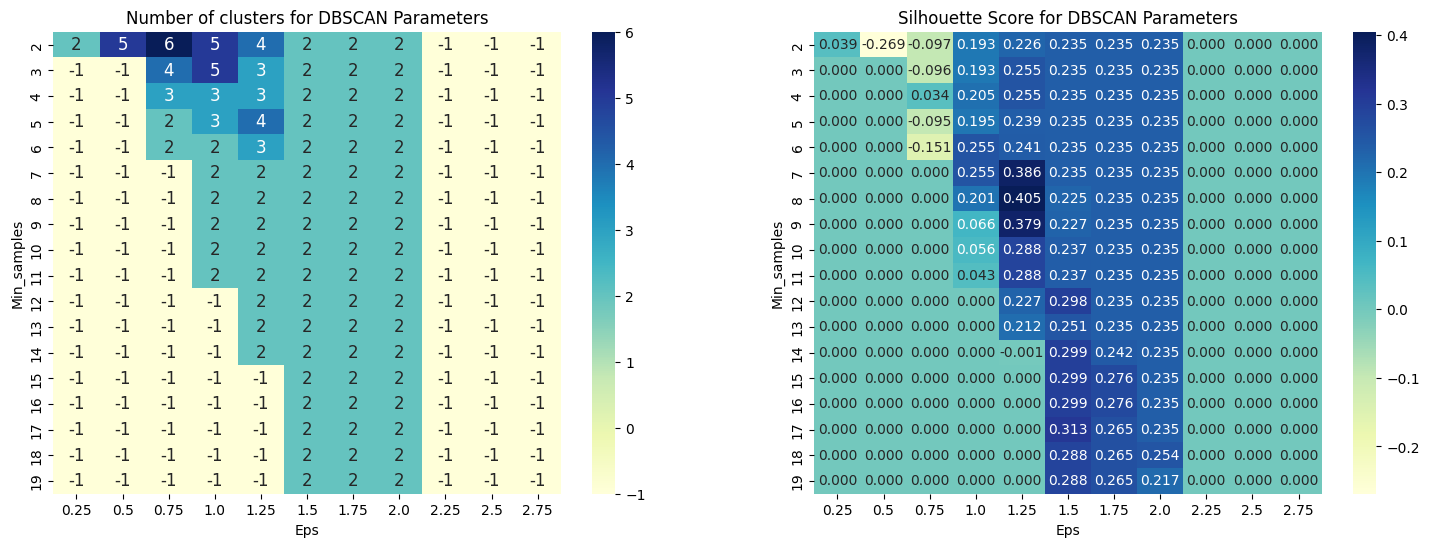

The heatmap on the left illustrates the number of clusters generated by the DBSCAN algorithm for different parameter combinations.
The heatmap on the right shows the corresponding silhouette scores for each parameter combination.


In [29]:
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

df = new_data[['Murder', 'Assault', 'UrbanPop', 'Rape']]
stscaler = StandardScaler()
X = stscaler.fit_transform(df)

eps_values = np.arange(0.25, 3, 0.25)
min_samples = np.arange(2, 20)
DBSCAN_params = list(product(eps_values, min_samples))

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    dbscan = DBSCAN(eps=p[0], min_samples=p[1])
    labels = dbscan.fit_predict(X)
    unique_labels = np.unique(labels)

    if len(unique_labels) > 1:
        no_of_clusters.append(len(unique_labels))
        sil_score.append(silhouette_score(X, labels))
    else:
        no_of_clusters.append(-1)
        sil_score.append(0.0)

tmp = pd.DataFrame.from_records(DBSCAN_params, columns=['Eps', 'Min_samples'])
tmp['No_of_clusters'] = no_of_clusters
tmp['Silhouette_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plotting the heatmap for number of clusters
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 12}, cmap="YlGnBu", ax=ax1)
ax1.set_title('Number of clusters for DBSCAN Parameters')
ax1.set_xlabel('Eps')
ax1.set_ylabel('Min_samples')

# Plotting the silhouette score
silhouette_scores = np.array(sil_score).reshape(len(eps_values), len(min_samples)).T
# silhouette_scores = np.array(sil_score).reshape(len(min_samples), len(eps_values))
sns.heatmap(silhouette_scores, annot=True, fmt=".3f", cmap="YlGnBu", ax=ax2, xticklabels=eps_values, yticklabels=min_samples)
ax2.set_title('Silhouette Score for DBSCAN Parameters')
ax2.set_xlabel('Eps')
ax2.set_ylabel('Min_samples')

plt.show()

print('The heatmap on the left illustrates the number of clusters generated by the DBSCAN algorithm for different parameter combinations.')
print('The heatmap on the right shows the corresponding silhouette scores for each parameter combination.')


In [30]:
data_filtered

Murder  Assault  UrbanPop  Rape  HC_labels_pred  HCN_labels_pred  \
0     13.2      236        58  21.2               1                0   
1     10.0      263        48  44.5               1                0   
2      8.1      294        80  31.0               1                3   
3      8.8      190        50  19.5               2                0   
4      9.0      276        91  40.6               1                3   
5      7.9      204        78  38.7               2                0   
6      3.3      110        77  11.1               0                1   
7      5.9      238        72  15.8               1                1   
8     15.4      335        80  31.9               1                3   
9     17.4      211        60  25.8               2                0   
10     5.3       46        83  20.2               0                1   
11     2.6      120        54  14.2               0                2   
12    10.4      249        83  24.0               1                3   
13     7.2      113        65  21.0               0                1   
14     2.2       56        57  11.3               0                2   
15     6.0      115        66  18.0               0                1   
16     9.7      109        52  16.3               0                2   
17    15.4      249        66  22.2               1                0   
18     2.1       83        51   7.8               0                2   
19    11.3      300        67  27.8               1                3   
20     4.4      149        85  16.3               2                1   
21    12.1      255        74  35.1               1                3   
22     2.7       72        66  14.9               0                1   
23    16.1      259        44  17.1               1                0   
24     9.0      178        70  28.2               2                0   
25     6.0      109        53  16.4               0                2   
26     4.3      102        62  16.5               0                2   
27    12.2      252        81  46.0               1                3   
28     2.1       57        56   9.5               0                2   
29     7.4      159        89  18.8               2                1   
30    11.4      285        70  32.1               1                3   
31    11.1      254        86  26.1               1                3   
32    13.0      337        45  16.1               1                0   
33     0.8       45        44   7.3               0                2   
34     7.3      120        75  21.4               0                1   
35     6.6      151        68  20.0               2                0   
36     4.9      159        67  29.3               2                0   
37     6.3      106        72  14.9               0                1   
38     3.4      174        87   8.3               2                1   
39    14.4      279        48  22.5               1                0   
40     3.8       86        45  12.8               0                2   
41    13.2      188        59  26.9               2                0   
42    12.7      201        80  25.5               2                0   
43     3.2      120        80  22.9               0                1   
44     2.2       48        32  11.2               0                2   
45     8.5      156        63  20.7               2                0   
46     4.0      145        73  26.2               2                0   
47     5.7       81        39   9.3               0                2   
48     2.6       53        66  10.8               0                1   
49     6.8      161        60  15.6               2                0   

    Kmeans_labels_pred  DBSCAN_labels_pred  
0                    1                   0  
1                    1                  -1  
2                    1                   1  
3                    2                   1  
4                    1                   2  
5                    2                   1  
6               